# **Processing of Clapping Motion Data Collected from Chest-Mounted Accelerometers at MusicLab Copenhagen Concert**

> Ahmet Emin Memis
> ahmeteminmemis@gmail.com
> 07.02.2022

Adjusted to process data as prepared for public release, with corrected alignment information and additional sensors. Finn Upham 20220415



During the MusicLab concert, audience members placed mobile phones on their chests which allowed us to collect their motion data while they are experiencing the concert. Some audience members without usable phones were lent accelerometer sensors (AX3).

Throuhout the concert, 15 clappings occurred either after speeches or musical pieces or at the end of the concert. This notebook processes the motion data of 85 participants during these clapping sections.

Section boundaries and thresholds reviewed Nov 12th, 2022

# Dependencies

In [15]:
# dependencies

import os
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

pd.options.mode.chained_assignment = None

In [16]:
# functions

def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y


# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [17]:
SAMPLE_RATE = 50
EXTEND_WINDOW = {1:5, 2:5, 3:5, 4:5}
DIR = './out_claps/' #windows path to output data

In [18]:
general_loc = '/Users/finn/Desktop/Current_Projects/Copen/'
internal_Part = general_loc + 'Participants_internal/'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [21]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

In [20]:
# Applause_ints=pd.read_csv('/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination/Clapping_rounds_3.csv', index_col=0)
Applause_ints= pd.read_csv('/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination/Clapping_rounds_4.csv')
Applause_ints

Unnamed: 0  start_time  end_time  duration           start_datetime  \
0            0     -691.20    -674.1     17.10  2021-10-26 17:36:34.800   
1            1     -555.90    -548.6      7.30  2021-10-26 17:38:50.100   
2            2       30.60      40.1      9.50  2021-10-26 17:48:36.600   
3            3     1610.60    1652.1     41.50  2021-10-26 18:14:56.600   
4            4     2004.80    2016.1     11.30  2021-10-26 18:21:30.800   
5            5     3282.60    3342.7     60.10  2021-10-26 18:42:48.600   
6            6     5001.92    5019.5     17.58  2021-10-26 19:11:27.920   
7            7     6020.10    6042.1     22.00  2021-10-26 19:28:26.100   
8            8     6759.10    6776.2     17.10  2021-10-26 19:40:45.100   
9            9     6933.40    6952.6     19.20  2021-10-26 19:43:39.400   
10          10     7170.30    7189.0     18.70  2021-10-26 19:47:36.300   
11          11     7537.40    7553.0     15.60  2021-10-26 19:53:43.400   
12          12     7748.70    7761.7     13.00  2021-10-26 19:57:14.700   
13          13     7771.30    7776.1      4.80  2021-10-26 19:57:37.300   
14          14     8042.60    8149.5    106.90  2021-10-26 20:02:08.600   

        Type Type_M      Texture  event_tag  Applause_N  ...  \
0   Entrance  Other  Independent    Entre 1           1  ...   
1     Speech  Other  Independent   Speech 1           2  ...   
2     Speech  Other  Independent   Speech 2           3  ...   
3      Music  Music        Mixed  Beethoven           4  ...   
4   Entrance  Other  Independent    Entre 2           5  ...   
5      Music  Music        Mixed  Schnittke           6  ...   
6   Entrance  Other  Independent    Entre 3           7  ...   
7      Music  Music  Independent       Bach           8  ...   
8      Music  Music  Independent     Folk 1           9  ...   
9      Music  Music  Independent     Folk 2          10  ...   
10     Music  Music  Independent     Folk 3          11  ...   
11     Music  Music  Independent     Folk 4          12  ...   
12     Music  Music  Independent     Folk 5          13  ...   
13    Speech  Other  Independent   Speech 3          14  ...   
14     Music  Music      Synched     Finale          15  ...   

                    cue_end_type cue_time2end  stage_next_time  \
0            Musician toward mic         3.10           -673.1   
1                      MC at Mic         3.30           -550.6   
2   Violinist pick up instrument         2.10             38.0   
3           Start to leave stage        25.50           1642.2   
4              Begin to sit down         3.30           2012.8   
5           Start to leave stage         6.10           3344.7   
6              Begin to sit down         4.58           5019.9   
7                 MC towards mic         5.00           6041.1   
8        Violinist ready to play         2.10           6776.7   
9          Violinist towards mic        12.20           6952.9   
10         Violinist towards mic         6.70           7190.1   
11          Violinist toward mic         3.60           7553.8   
12          Violinist toward mic         5.00           7762.9   
13             MC starts talking         0.60           7775.5   
14          Start to leave stage        10.70           8144.8   

                 stage_next_type stage_next_time2  \
0                 Start to speak             -1.0   
1              MC starts talking              2.0   
2   Violinist pick up instrument              2.1   
3              MC starts talking              9.9   
4              Begin to sit down              3.3   
5                      MC at mic             -2.0   
6              MC starts talking             -0.4   
7              MC starts talking              1.0   
8                Violinist plays             -0.5   
9      Violinist begins to speak             -0.3   
10     Violinist begins to speak             -1.1   
11     Violinist begins to speak             -0.8   
12     Violinist begins to speak

In [5]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 # 1637.2253 in audio
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
concert_times.iloc[:5]

Event  Time_s_Start  Time_ms_Start  \
Time_dt_Start                                                       
2021-10-26 17:36:32.760      Claps 1       -693.24      -693240.0   
2021-10-26 17:36:50.820  MC Speach 1       -675.18      -675180.0   
2021-10-26 17:38:47.960      Claps 2       -558.04      -558040.0   
2021-10-26 17:38:53.840  MC Speach 2       -552.16      -552160.0   
2021-10-26 17:47:58.840  Synch cue 1         -7.16        -7160.0   

                         Time_Stream_Start              Time_dt_End  \
Time_dt_Start                                                         
2021-10-26 17:36:32.760             946.00  2021-10-26 17:36:49.840   
2021-10-26 17:36:50.820             964.06  2021-10-26 17:38:47.780   
2021-10-26 17:38:47.960            1081.20  2021-10-26 17:38:55.880   
2021-10-26 17:38:53.840            1087.08  2021-10-26 17:48:18.380   
2021-10-26 17:47:58.840            1632.08  2021-10-26 17:48:35.460   

                         Time_s_End  Time_ms_End  Time_Stream_End  sequence  \
Time_dt_Start                                                                 
2021-10-26 17:36:32.760     -676.16    -676160.0           963.08         0   
2021-10-26 17:36:50.820     -558.22    -558220.0          1081.02         1   
2021-10-26 17:38:47.960     -550.12    -550120.0          1089.12         2   
2021-10-26 17:38:53.840       12.38      12380.0          1651.62         3   
2021-10-26 17:47:58.840       29.46      29460.0          1668.70         4   

                         Event_Duration       Event_Type  
Time_dt_Start                                             
2021-10-26 17:36:32.760           17.08         Applause  
2021-10-26 17:36:50.820          116.96           Speach  
2021-10-26 17:38:47.960            7.92         Applause  
2021-10-26 17:38:53.840          564.54           Speach  
2021-10-26 17:47:58.840           36.62  Synchronisation

In [22]:
df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','end_time_concert','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
df_clappings['section_id'] = Applause_ints['Applause_N']
df_clappings['start_time_concert'] = Applause_ints['start_time'] 
df_clappings['end_time_concert'] = Applause_ints['end_time']
df_clappings['tag'] = Applause_ints['event_tag'] 
df_clappings['clapping_type'] = Applause_ints['Texture']
df_clappings

section_id  start_time_concert  end_time_concert        tag clapping_type
0            1             -691.20            -674.1    Entre 1   Independent
1            2             -555.90            -548.6   Speech 1   Independent
2            3               30.60              40.1   Speech 2   Independent
3            4             1610.60            1652.1  Beethoven         Mixed
4            5             2004.80            2016.1    Entre 2   Independent
5            6             3282.60            3342.7  Schnittke         Mixed
6            7             5001.92            5019.5    Entre 3   Independent
7            8             6020.10            6042.1       Bach   Independent
8            9             6759.10            6776.2     Folk 1   Independent
9           10             6933.40            6952.6     Folk 2   Independent
10          11             7170.30            7189.0     Folk 3   Independent
11          12             7537.40            7553.0     Folk 4   Independent
12          13             7748.70            7761.7     Folk 5   Independent
13          14             7771.30            7776.1   Speech 3   Independent
14          15             8042.60            8149.5     Finale       Synched

In [23]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

Participant_Code  Participant_Number Attendance Questionnaire_Language  \
0            ADQ001                   1          A                      D   
1            ADQ002                   2          A                      D   
2            ADQ003                   3          A                      D   
3            ADQ004                   4          A                      D   
4            ADQ005                   5          A                      D   
..              ...                 ...        ...                    ...   
80           AEQ086                  86          A                      E   
81           AEQ087                  87          A                      E   
82           AEQ088                  88          A                      E   
83           AEQ089                  89          A                      E   
84           AER090                  90          A                      E   

   Motion_Quality  Link_Conflicts  Seat_Zone Location  Longitude_Truncated  \
0               Q               0        6.0      NaN                  NaN   
1               Q               0        3.0      NaN                  NaN   
2               Q               0        2.0      NaN                  NaN   
3               Q               0        4.0      NaN                  NaN   
4               Q               0        4.0      NaN                  NaN   
..            ...             ...        ...      ...                  ...   
80              Q               0        5.0      NaN                  NaN   
81              Q               1        3.0      NaN                  NaN   
82              Q               0        2.0      NaN                  NaN   
83              Q               0        4.0      NaN                  NaN   
84              R               1        3.0      NaN                  NaN   

    Lattitude_Truncated  Offset_1  Offset_2  Watch_Alone  
0                   NaN      0.14      0.16          0.0  
1                   NaN       NaN     -0.36          0.0  
2                   NaN      0.88      1.02          0.0  
3                   NaN      0.44      0.62          1.0  
4                   NaN      0.04      0.12          0.0  
..                  ...       ...       ...          ...  
80                  NaN       NaN      0.34          0.0  
81                  NaN      0.12      0.28          0.0  
82                  NaN      0.10      0.06          0.0  
83                  NaN      0.28      0.38          0.0  
84                  NaN      0.94      1.06          0.0  

[85 rows x 13 columns]

# Read data

Check aligned motion data, csv files for each device.

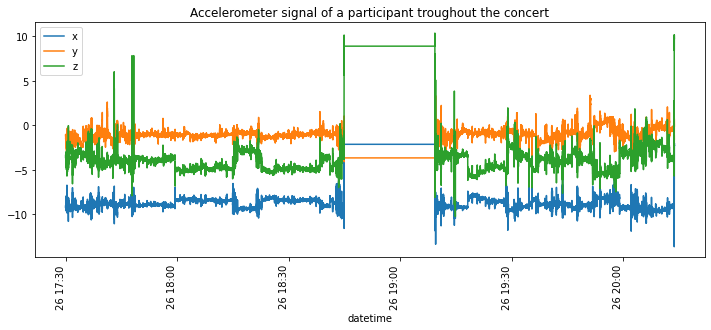

In [24]:
# devices
# dir_devices = DIR + 'Aligned/Hall/' # path to aligned accelerometer hall data
# list_devices = np.array(os.listdir(dir_devices))
# device_tags = [s.split('.')[0] for s in list_devices]

i = 4
participant = alignedParts.loc[i,:]

part = participant['Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format


inst_d.plot(x='datetime', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

#device_tags, len(device_tags)

---
Start and end times indicate the first and the last claps heard in the concert hall. _'tag'_ is for explanations of clappings and used in file names. _clapping_type_ field indicates the relation of clappings, where _1_ indicates the clappings related to speeches or events occurred on the stage, _2_ is for the ones after pieces by Beethoven, Schnittke and Bach. _3_ is for the ones after the folk music pieces and _4_ indicates the final applause at the end of the concert.

In [25]:
print(Applause_ints.columns)
Applause_ints.loc[:3,:]

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'start_datetime',
       'Type', 'Type_M', 'Texture', 'event_tag', 'Applause_N',
       'cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_time', 'stage_next_type',
       'stage_next_time2', 'files', 'links', 'Links_time(s)', 'Vid_times',
       'Links_ctime(s)'],
      dtype='object')


Unnamed: 0  start_time  end_time  duration           start_datetime  \
0           0      -691.2    -674.1      17.1  2021-10-26 17:36:34.800   
1           1      -555.9    -548.6       7.3  2021-10-26 17:38:50.100   
2           2        30.6      40.1       9.5  2021-10-26 17:48:36.600   
3           3      1610.6    1652.1      41.5  2021-10-26 18:14:56.600   

       Type Type_M      Texture  event_tag  Applause_N  ...  \
0  Entrance  Other  Independent    Entre 1           1  ...   
1    Speech  Other  Independent   Speech 1           2  ...   
2    Speech  Other  Independent   Speech 2           3  ...   
3     Music  Music        Mixed  Beethoven           4  ...   

                   cue_end_type cue_time2end  stage_next_time  \
0           Musician toward mic          3.1           -673.1   
1                     MC at Mic          3.3           -550.6   
2  Violinist pick up instrument          2.1             38.0   
3          Start to leave stage         25.5           1642.2   

                stage_next_type stage_next_time2  \
0                Start to speak             -1.0   
1             MC starts talking              2.0   
2  Violinist pick up instrument              2.1   
3             MC starts talking              9.9   

                            files                                links  \
0    Applause_1_entre_1_peaks.csv  https://youtu.be/S4UVJybA6ZQ?t=1294   
1   Applause_2_speech_1_peaks.csv  https://youtu.be/S4UVJybA6ZQ?t=1430   
2   Applause_3_speech_2_peaks.csv  https://youtu.be/S4UVJybA6ZQ?t=2018   
3  Applause_4_beethoven_peaks.csv  https://youtu.be/S4UVJybA6ZQ?t=3596   

  Links_time(s)  Vid_times Links_ctime(s)  
0          1294          0           -692  
1          1430         25           -556  
2          2018         41             32  
3          3596         57           1610  

[4 rows x 24 columns]

In [26]:
df_clappings

section_id  start_time_concert  end_time_concert        tag clapping_type
0            1             -691.20            -674.1    Entre 1   Independent
1            2             -555.90            -548.6   Speech 1   Independent
2            3               30.60              40.1   Speech 2   Independent
3            4             1610.60            1652.1  Beethoven         Mixed
4            5             2004.80            2016.1    Entre 2   Independent
5            6             3282.60            3342.7  Schnittke         Mixed
6            7             5001.92            5019.5    Entre 3   Independent
7            8             6020.10            6042.1       Bach   Independent
8            9             6759.10            6776.2     Folk 1   Independent
9           10             6933.40            6952.6     Folk 2   Independent
10          11             7170.30            7189.0     Folk 3   Independent
11          12             7537.40            7553.0     Folk 4   Independent
12          13             7748.70            7761.7     Folk 5   Independent
13          14             7771.30            7776.1   Speech 3   Independent
14          15             8042.60            8149.5     Finale       Synched

In [13]:
df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','end_time_concert','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
df_clappings['section_id'] = Applause_ints['Applause_N']
df_clappings['start_time_concert'] = Applause_ints['start_time'] #concert_applause['Time_s_Start'].values
#df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = Applause_ints['end_time']#concert_applause['Time_s_End'].values
#df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = Applause_ints['event_tag'] 
df_clappings['clapping_type'] = Applause_ints['Texture']#[1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]
df_clappings

section_id  start_time_concert  end_time_concert        tag clapping_type
0            1              -688.4            -672.4    Entre 1   Independent
1            2              -553.4            -546.4   Speech 1   Independent
2            3                33.6              42.6   Speech 2   Independent
3            4              1613.6            1654.6  Beethoven         Mixed
4            5              2009.6            2019.6    Entre 2   Independent
5            6              3285.6            3345.6  Schnittke         Mixed
6            7              5005.6            5021.6    Entre 3   Independent
7            8              6022.6            6044.6       Bach   Independent
8            9              6761.6            6778.6     Folk 1   Independent
9           10              6935.6            6955.6     Folk 2   Independent
10          11              7172.6            7191.6     Folk 3   Independent
11          12              7540.6            7555.6     Folk 4   Independent
12          13              7751.6            7764.6     Folk 5   Independent
13          14              7777.6            7781.6   Speech 3   Independent
14          15              8045.6            8152.6     Finale       Synched

df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','start_time','end_time_concert','end_time','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
df_clappings['section_id'] = range(len(tags))
df_clappings['start_time_concert'] = concert_applause['Time_s_Start'].values
df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = concert_applause['Time_s_End'].values
df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = tags
df_clappings['clapping_type'] = [1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]
df_clappings

# Create datasets for clapping sections

This section is to process the accelerometer data and create datasets for each clapping interval.


In [27]:
# Step one, import the motion data at 50 Hz

# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 100

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,gap_t)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='Q':
        aud_df[part] = b
    else:
        aud_df[part] = b*6 # correction factor for AX3s. Approximate

aud_df.index = dt_ct

In [61]:
ts_ct/1000

array([-1086.        , -1085.98      , -1085.96      , ...,
        9714.93999999,  9714.95999999,  9714.97999999])

In [65]:
full_motion_50hz_df = aud_df.copy()
full_motion_50hz_df.index = ts_ct#/1000


In [66]:
full_motion_50hz_df # 1637.2253

ADQ001  ADQ002    ADQ003    ADQ004    ADQ005    ADQ006  \
-1.086000e+06       NaN     NaN       NaN       NaN       NaN       NaN   
-1.085980e+06       NaN     NaN       NaN       NaN       NaN       NaN   
-1.085960e+06  0.222090   0.075  0.150520  0.000000  0.022368  0.057934   
-1.085940e+06  0.239801   0.200  0.063017  0.141421  0.043218  0.226986   
-1.085920e+06  0.195506   0.000  0.134267  0.141421  0.078329  0.104051   
...                 ...     ...       ...       ...       ...       ...   
 9.714900e+06       NaN     NaN       NaN       NaN       NaN       NaN   
 9.714920e+06       NaN     NaN       NaN       NaN       NaN       NaN   
 9.714940e+06       NaN     NaN       NaN       NaN       NaN       NaN   
 9.714960e+06       NaN     NaN       NaN       NaN       NaN       NaN   
 9.714980e+06       NaN     NaN       NaN       NaN       NaN       NaN   

                 ADQ007    ADQ008    ADQ009    ADQ010  ...    AEQ081  \
-1.086000e+06       NaN       NaN       NaN       NaN  ...       NaN   
-1.085980e+06       NaN       NaN       NaN       NaN  ...       NaN   
-1.085960e+06  0.061871  0.010210  0.153236  0.062374  ...  0.267754   
-1.085940e+06  0.248541  0.028212  0.261131  0.064686  ...  0.103519   
-1.085920e+06  0.411185  0.025844  0.121351  0.045601  ...  0.229614   
...                 ...       ...       ...       ...  ...       ...   
 9.714900e+06       NaN       NaN       NaN       NaN  ...       NaN   
 9.714920e+06       NaN       NaN       NaN       NaN  ...       NaN   
 9.714940e+06       NaN       NaN       NaN       NaN  ...       NaN   
 9.714960e+06       NaN       NaN       NaN       NaN  ...       NaN   
 9.714980e+06       NaN       NaN       NaN       NaN  ...       NaN   

                 AEQ082  AEQ083    AEQ084  AEQ085  AEQ086    AEQ087    AEQ088  \
-1.086000e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
-1.085980e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
-1.085960e+06  0.053526     NaN  0.058078     NaN     NaN  0.040438  0.245602   
-1.085940e+06  0.178591     NaN  0.025165     NaN     NaN  0.077260  0.143217   
-1.085920e+06  0.109458     NaN  0.024184     NaN     NaN  0.094269  0.464429   
...                 ...     ...       ...     ...     ...       ...       ...   
 9.714900e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
 9.714920e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
 9.714940e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
 9.714960e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   
 9.714980e+06       NaN     NaN       NaN     NaN     NaN       NaN       NaN   

                 AEQ089    AER090  
-1.086000e+06       NaN       NaN  
-1.085980e+06       NaN       NaN  
-1.085960e+06  0.094118  0.006460  
-1.085940e+06  0.094118  0.081736  
-1.085920e+06  0.047059  0.074169  
...                 ...       ...  
 9.714900e+06       NaN       NaN  
 9.714920e+06       NaN       NaN  
 9.714940e+06       NaN       NaN  
 9.714960e+06       NaN       NaN  
 9.714980e+06       NaN       NaN  

[540050 rows x 85 columns]

<AxesSubplot:>

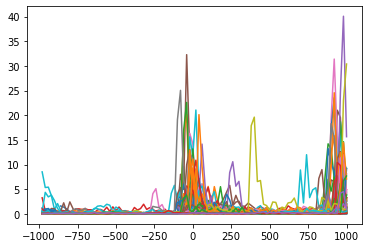

In [67]:
full_motion_50hz_df.loc[-1000:1000,:].plot(legend = False)

## Cutting the segments of audience motion to applause intervals

This next section cuts the synchronised audience motion recordings to segments that include applause. The applause intervals were evaluated from the audio of the broadcast stream recordings, from the first audible to the last audible clap per round of applause, with time values in seconds from concert zero (first tap of firt synchronisation protocal). These timing values are stored in 

Applause_ints= pd.read_csv('/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination/Clapping_rounds_4.csv')

with essential detail extracted to df_clappings in the cells above.

This segmentation extends these intervals by 5 seconds on either side. This helps with setting a reasonable threshold per device. Time values per interval are set to zero at the clapping start time. 

Files produced are sent to 

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/'

with file names specifying the applause round and prompt. 

In [87]:
# Step two, cut and save these per segment.

# low pass filter
T = 10.0        # sample period
fs = 50.0       # Hz
cutoff = 12.5   # cutoff frequency of the filter # Hz
nyq = 0.5 * fs  # nyquist frequency
order = 2 
n = int(T * fs)
extend = 5 # all the samples are cut with a 5 s buffer on clapping interval, before and after

output_dir = DIR # + 'Concert_content/clapping_motion/'

for ev_idx in range(len(df_clappings)):
    ev_in, ev_out, ev_type, ev_tag = df_clappings.loc[ev_idx, ['start_time_concert', 'end_time_concert', 'clapping_type', 'tag']]

    in_event_time = (ev_in - extend) * 10**3
    out_event_time = (ev_out + extend) * 10**3
    
    df_seg = full_motion_50hz_df.loc[in_event_time:out_event_time].copy()
    print('section:', ev_tag, (ev_in, ev_out), (in_event_time, out_event_time),len(df_seg))

    ts_ev = np.round(df_seg.index - df_seg.index[0]-extend * 10**3) # not in date time for now, just ms
    df_section = pd.DataFrame(index = ts_ev,columns = aud_df.columns)
    for dev_n in df_seg.columns:
        #print('   ', dev_n)
        df_clap = df_seg.loc[:,dev_n]
        data_raw = df_clap[~np.isnan(df_clap)]
        if data_raw.shape[0] > 10:
            data_filtered = butter_lowpass_filter(data_raw, cutoff, fs, order)
        else:
            #data_raw[f.split('.')[0]] = np.nan
            data_filtered = data_raw
        df_clap.loc[data_raw.index] = data_filtered
        # save clapping interval as df
        df_section[dev_n] = df_clap.values
    # save clapping section as csv file
#     df_section['Applause_s'] = (df_section.index - in_event_time)/1000
#    df_section.index = pd.to_datetime(df_section.index, unit='ms').strftime('%H:%M:%S.%f')
#     df_section.index = (df_section.index - in_event_time)/1000
    df_section.index.name = 'index'
    fileName = 'Applause_' + str(ev_idx+1) + '_' + ev_tag.lower().replace(' ','_') + '_motion.csv'
    print(fileName)
    df_section.to_csv(output_dir + fileName)



section: Entre 1 (-691.2, -674.1) (-696200.0, -669100.0) 1355
Applause_1_entre_1_motion.csv
section: Speech 1 (-555.9, -548.6) (-560900.0, -543600.0) 865
Applause_2_speech_1_motion.csv
section: Speech 2 (30.6, 40.1) (25600.0, 45100.0) 975
Applause_3_speech_2_motion.csv
section: Beethoven (1610.6, 1652.1) (1605600.0, 1657100.0) 2575
Applause_4_beethoven_motion.csv
section: Entre 2 (2004.8, 2016.1) (1999800.0, 2021100.0) 1065
Applause_5_entre_2_motion.csv
section: Schnittke (3282.6, 3342.7) (3277600.0, 3347700.0) 3505
Applause_6_schnittke_motion.csv
section: Entre 3 (5001.92, 5019.5) (4996920.0, 5024500.0) 1379
Applause_7_entre_3_motion.csv
section: Bach (6020.1, 6042.1) (6015100.0, 6047100.0) 1600
Applause_8_bach_motion.csv
section: Folk 1 (6759.1, 6776.2) (6754100.0, 6781200.0) 1355
Applause_9_folk_1_motion.csv
section: Folk 2 (6933.4, 6952.6) (6928400.0, 6957600.0) 1460
Applause_10_folk_2_motion.csv
section: Folk 3 (7170.3, 7189.0) (7165300.0, 7194000.0) 1435
Applause_11_folk_3_motion

In [134]:
output_dir

'./out_claps/'

In [135]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping'

# Focus on individual claps 

For further analysis, we extracted the time and amplitude values of each clap using peak picking and thresholding. To pick the clapping peaks out of the signal, a RMS and standard deviation based threshold is applied to the signal. By manually testing different weights for rms and std, 1 and 0.8 are selected as they provided the best performance in distinguishing the clapping and noise peaks.

This section outputs `*_trimmed` and `*_peaks` files, which contain individual clapping intervals and selected peaks respectively.

In [73]:
DIR

'./out_claps/'

In [133]:
pwd + DIR

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping'

In [74]:
path_clapping_motion = DIR #+ 'Concert_content/clapping_motion/'
list_files = os.listdir(path_clapping_motion)
list_files

['Applause_5_entre_2_motion.csv',
 'Applause_4_beethoven_motion.csv',
 '.DS_Store',
 'Applause_3_speech_2_motion.csv',
 'Applause_8_bach_motion.csv',
 'Applause_1_entre_1_motion.csv',
 'clapping_trimmed',
 'Applause_11_folk_3_motion.csv',
 'Applause_15_finale_motion.csv',
 'Applause_7_entre_3_motion.csv',
 'Applause_12_folk_4_motion.csv',
 'Applause_6_schnittke_motion.csv',
 'Applause_14_speech_3_motion.csv',
 'Applause_9_folk_1_motion.csv',
 'Applause_2_speech_1_motion.csv',
 'clapping_peaks',
 'Applause_10_folk_2_motion.csv',
 'Applause_13_folk_5_motion.csv']

### test threshold

In [76]:
f = list_files[7]
print(f)
# read data
df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
df_motion.index = df_motion.index/1000 #pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)

thr_list = []


Applause_11_folk_3_motion.csv


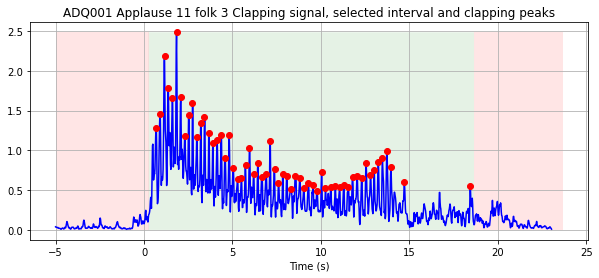

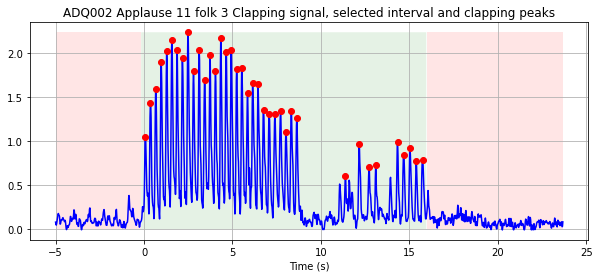

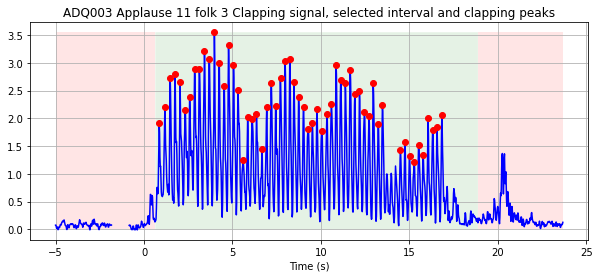

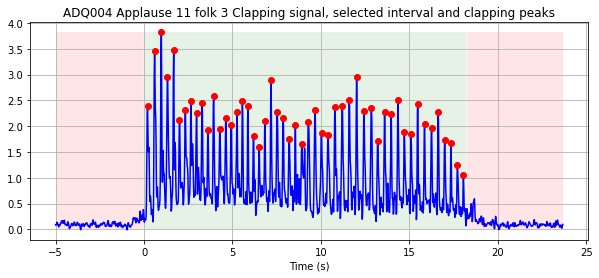

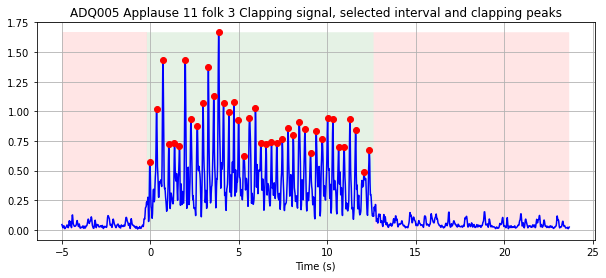

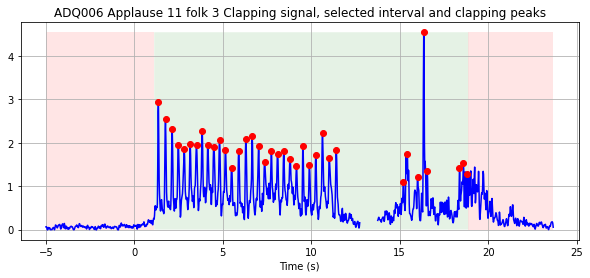

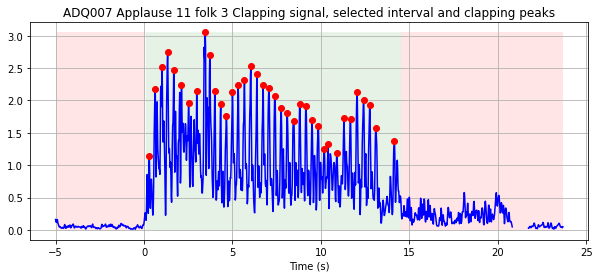

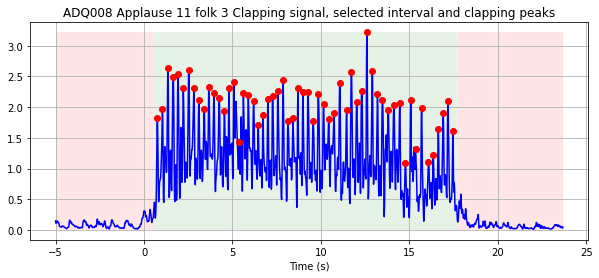

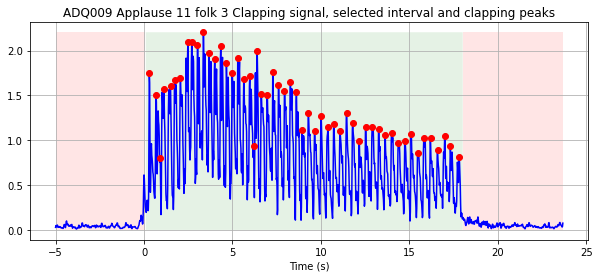

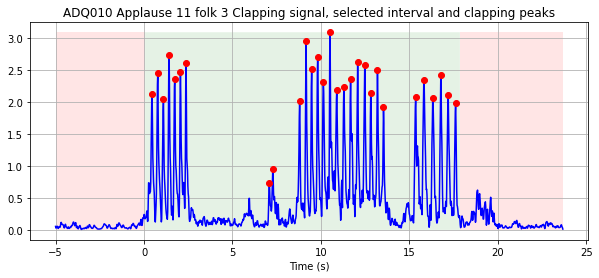

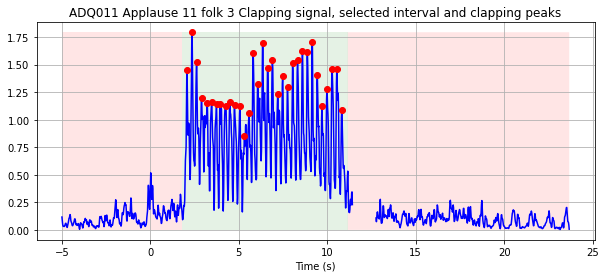

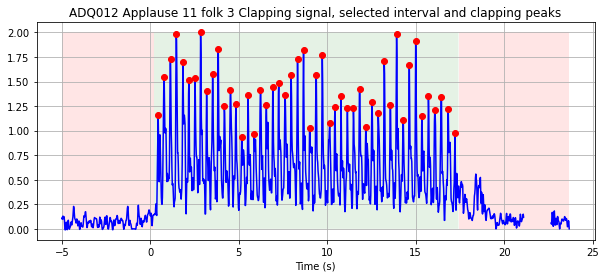

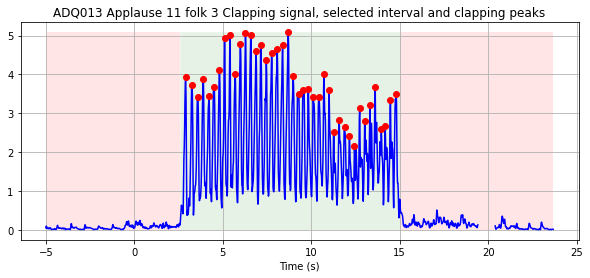

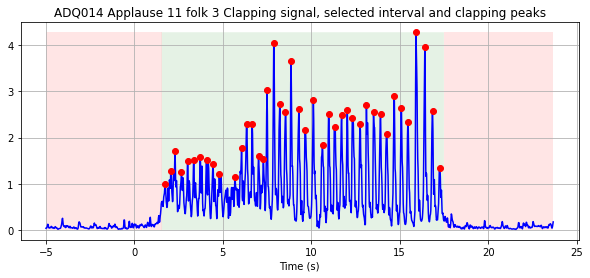

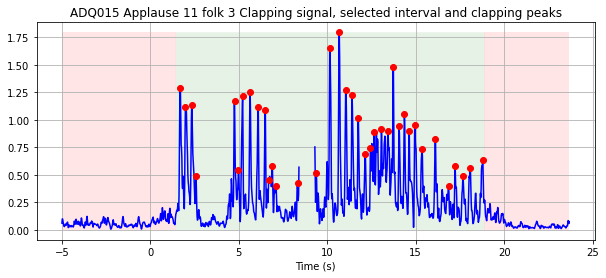

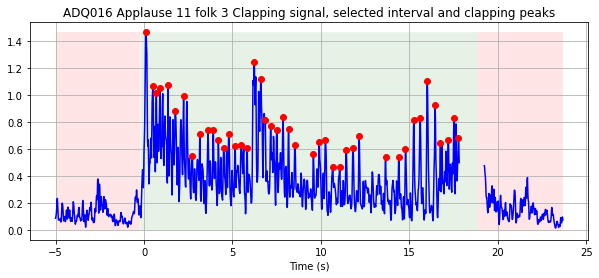

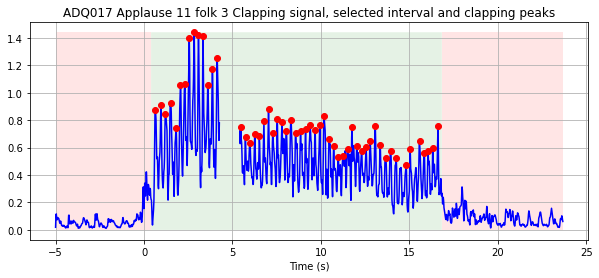

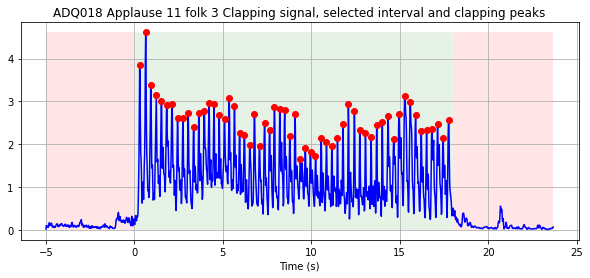

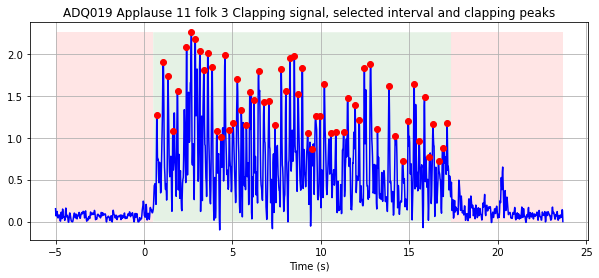

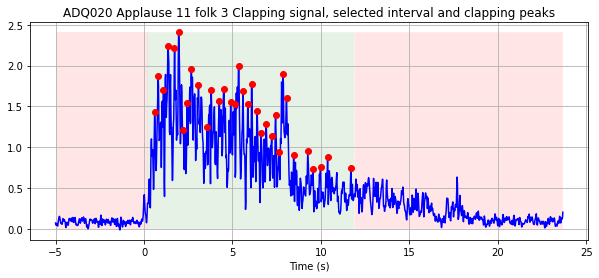

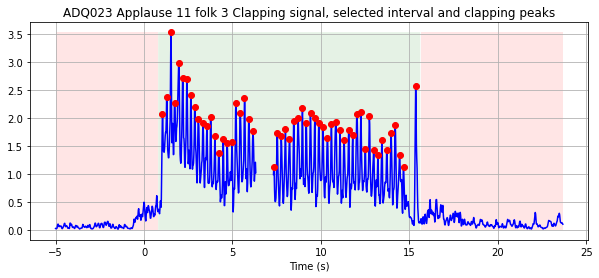

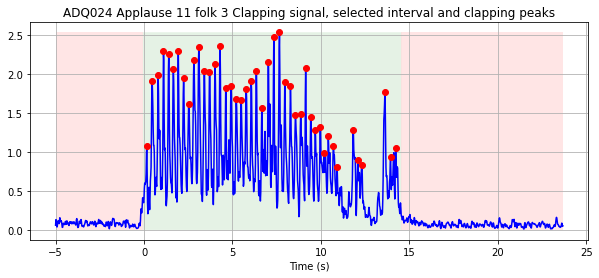

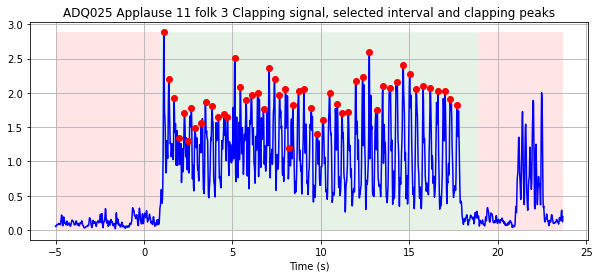

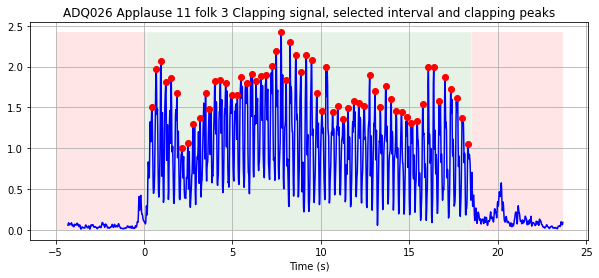

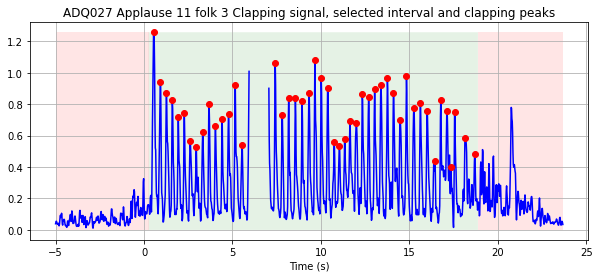

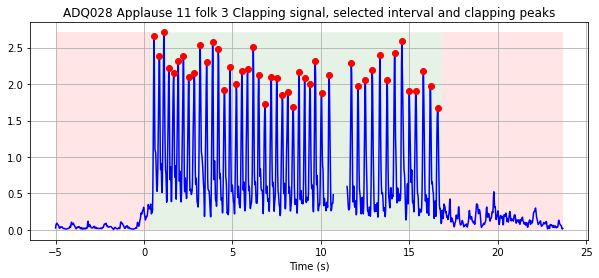

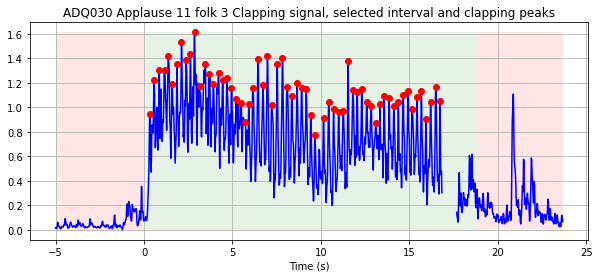

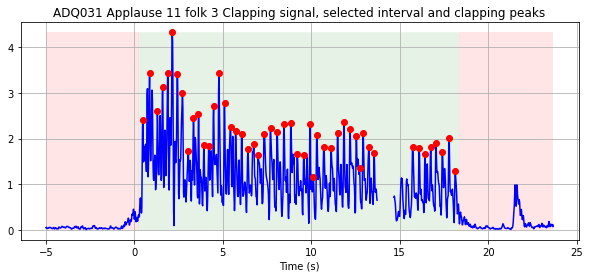

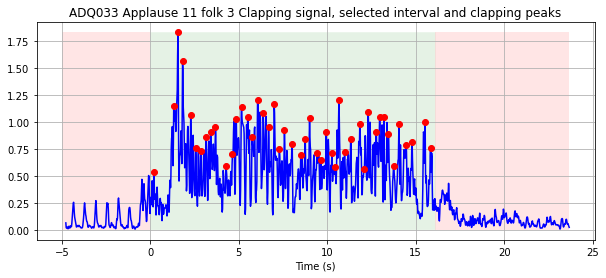

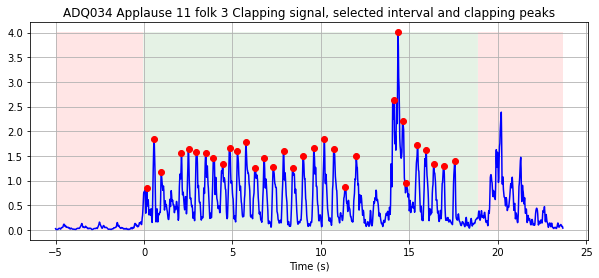

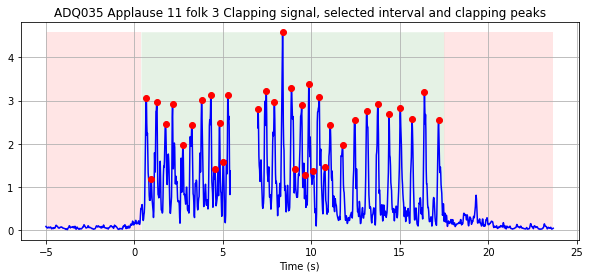

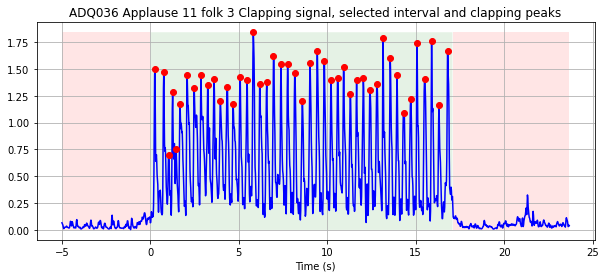

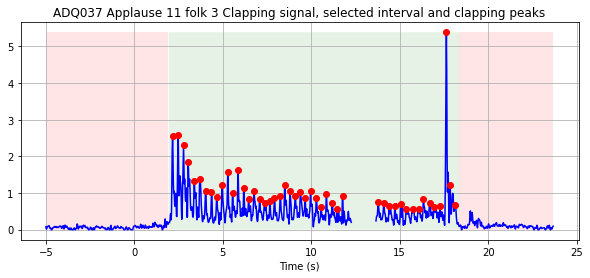

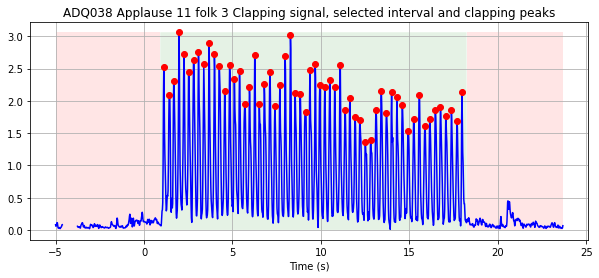

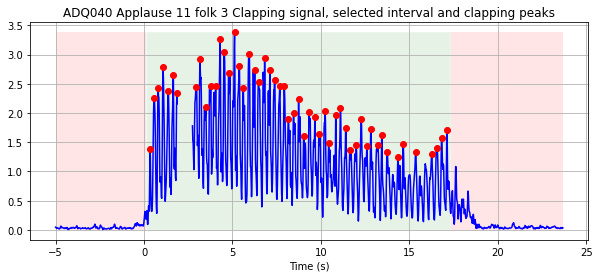

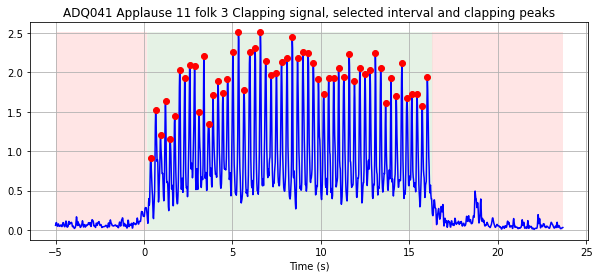

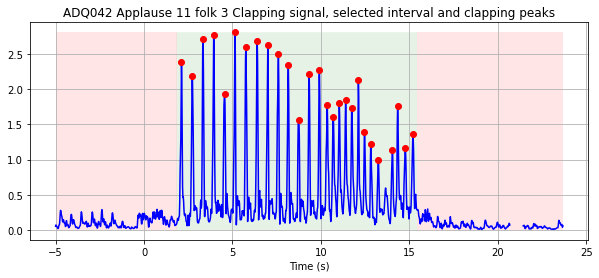

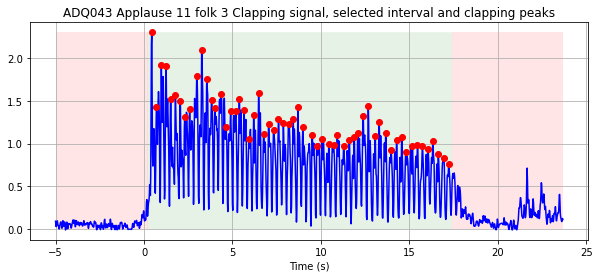

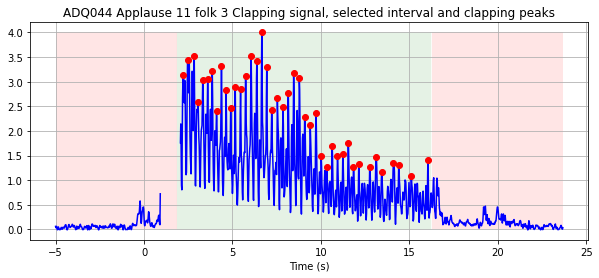

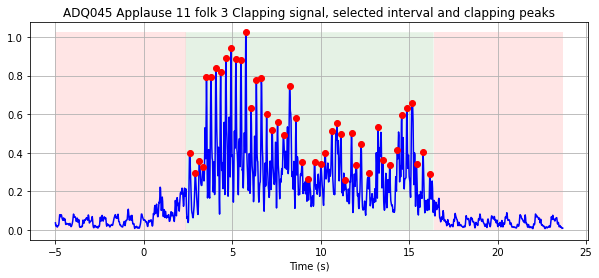

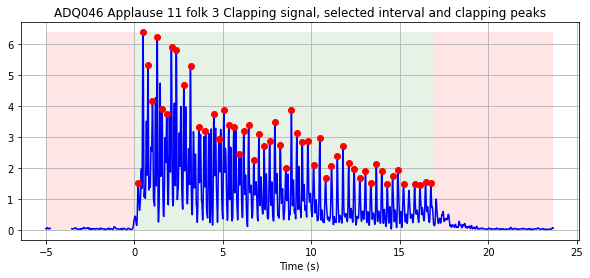

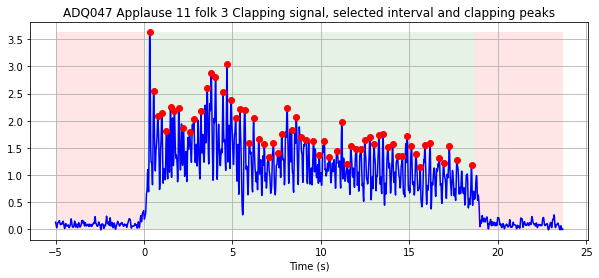

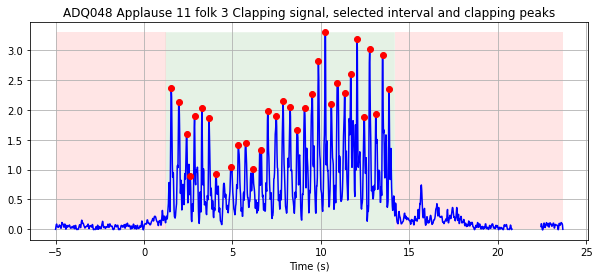

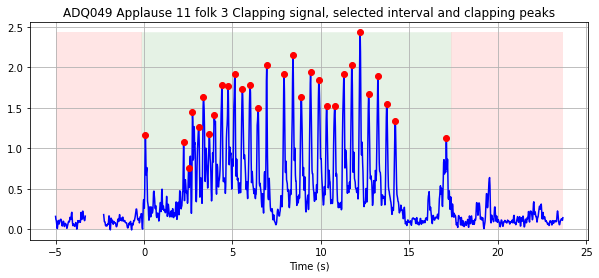

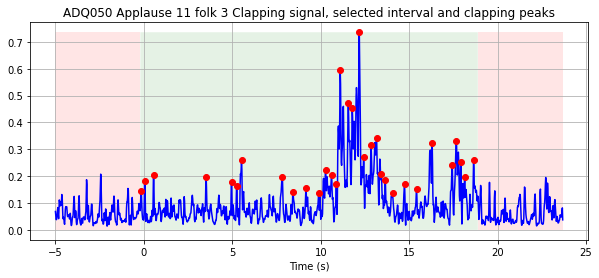

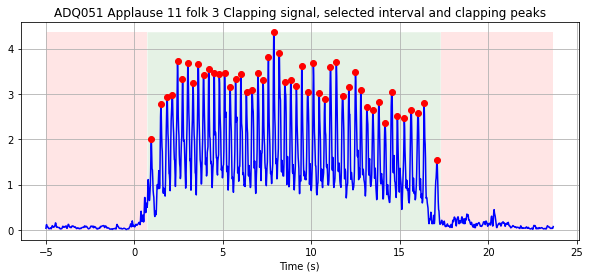

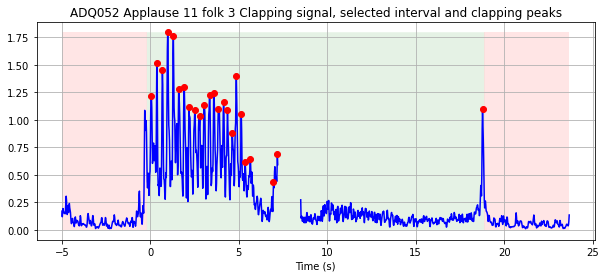

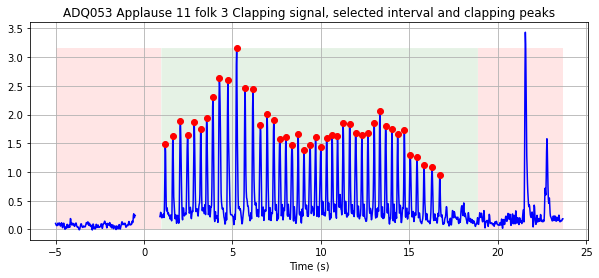

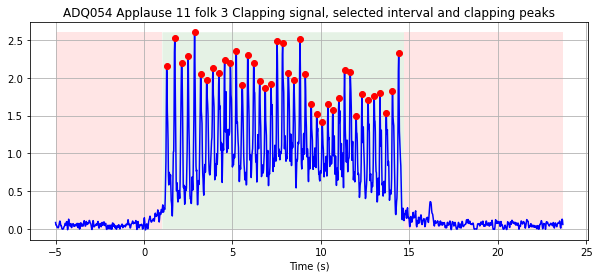

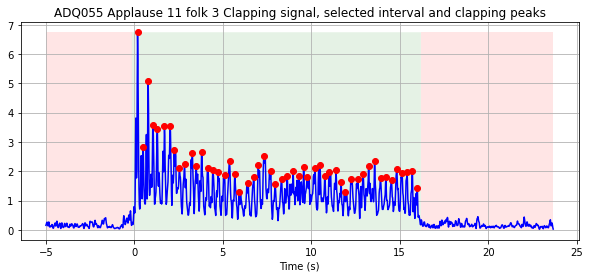

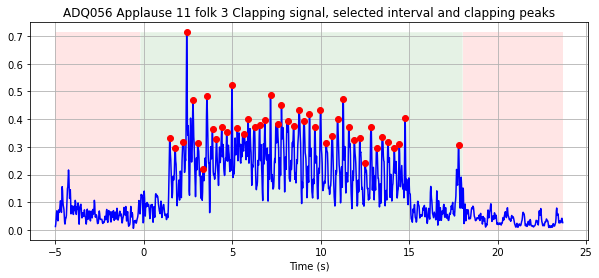

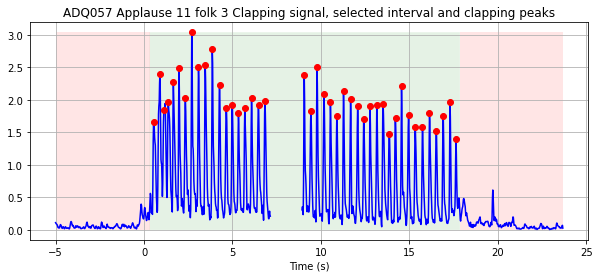

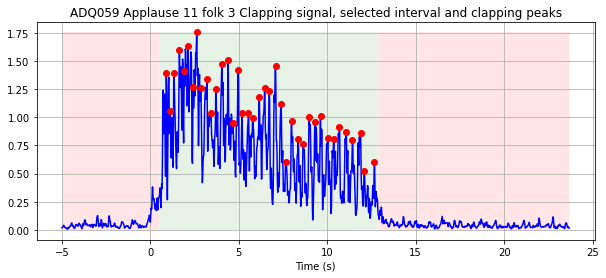

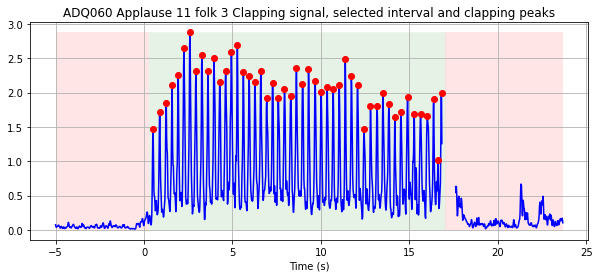

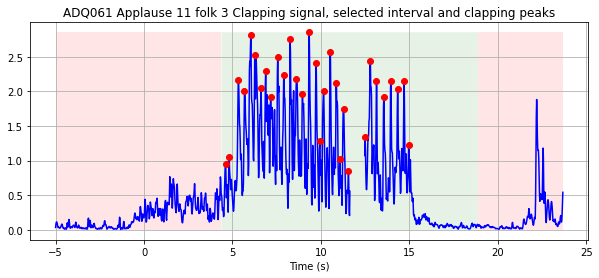

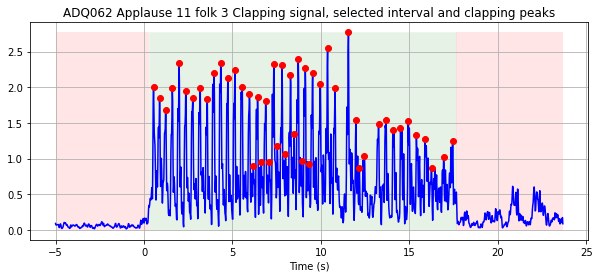

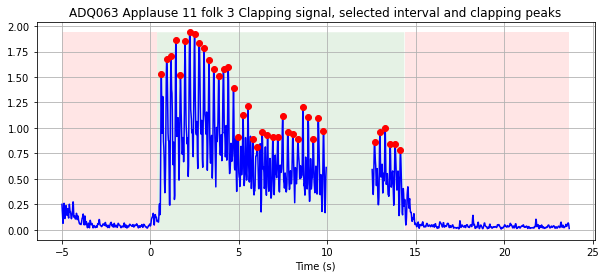

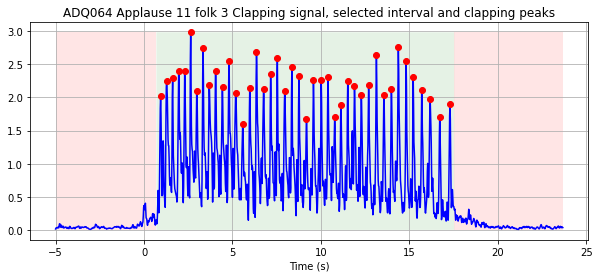

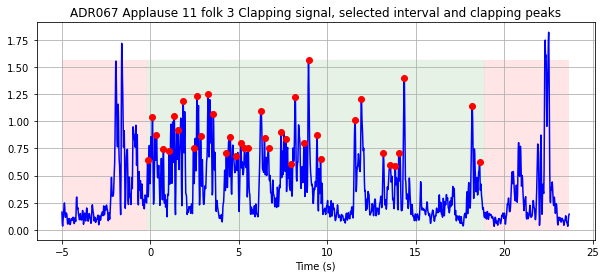

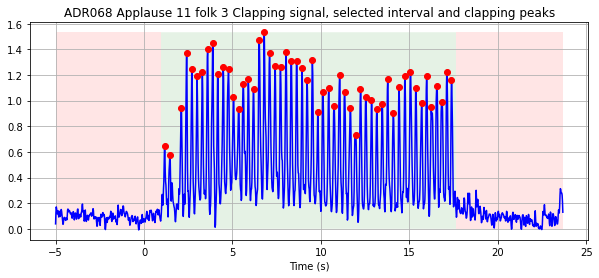

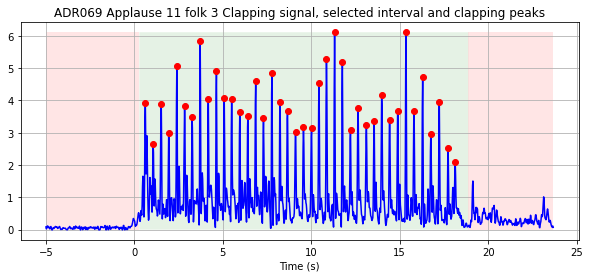

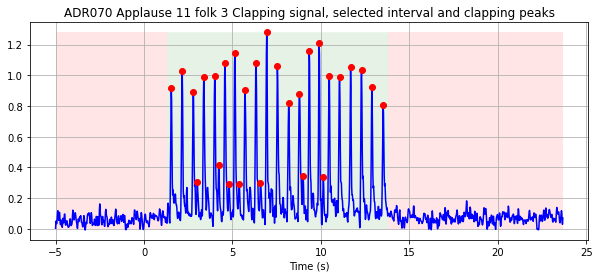

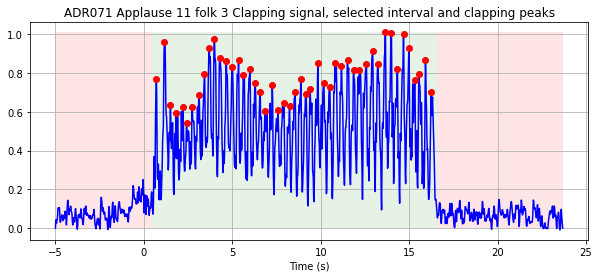

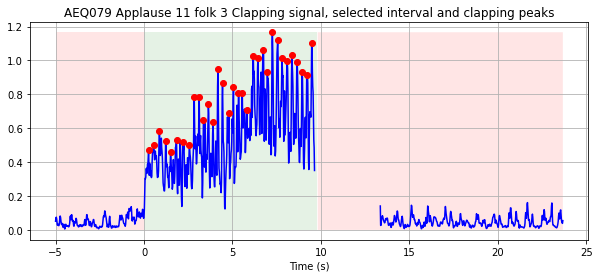

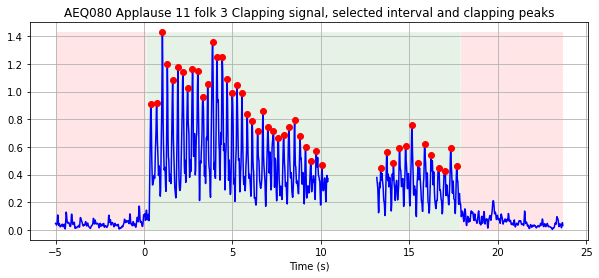

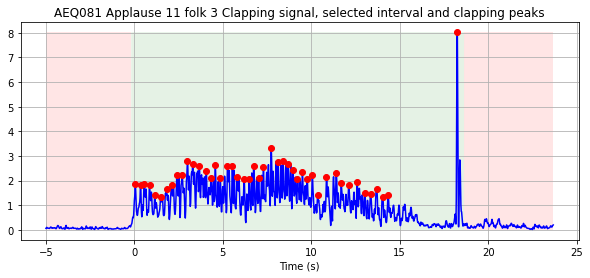

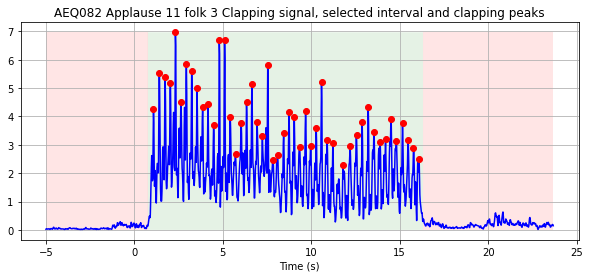

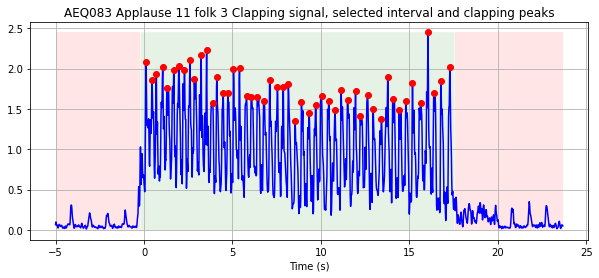

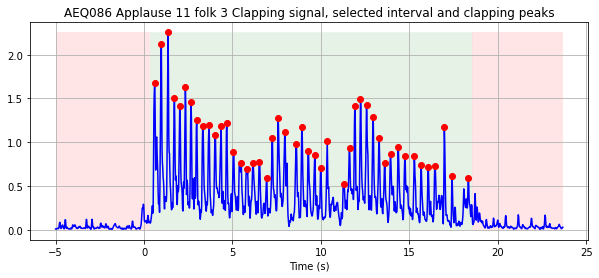

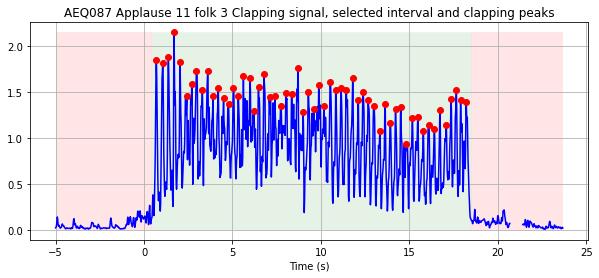

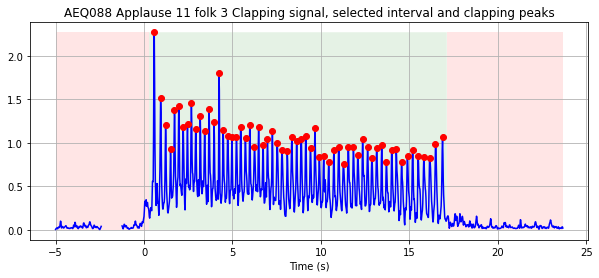

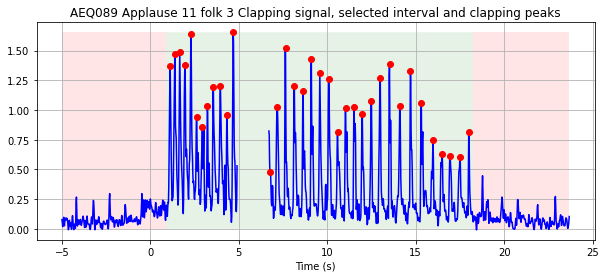

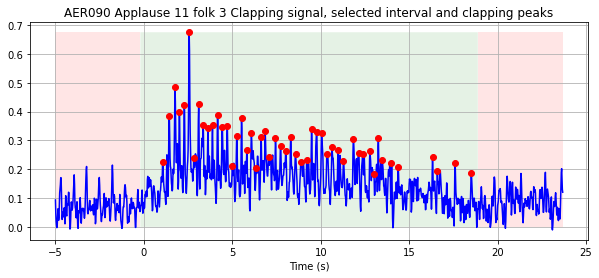

In [109]:
# read data
df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
df_motion.index = df_motion.index/1000
#df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()
extend_seg = 5 # five seconds was the extension given to the segments being evaluated
extend_ind = 5*fs # segmentation extension, in number of samples
extend = 10 * 0.02 # extending the evaluation windows for peak picking by 0.2 s in samples

seg_len=len(df_motion)

# create dataframes for each output csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)

thr_list = []
thr=0.01
std_thr = 0.08

# run through the columns 
for i, col in enumerate(df_ev.columns):
    # extract the rms of this participants motion through segment intervals (clapping +/- 5 s)
    rms = rms_signal(df_ev[col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
    df_rms[col] = rms['rms']
    
    # establish a threshold value for signal rms values where peaks will be counted.
    std = np.std(df_ev[col])
    thr = rms.mean()[0] + std*0.35
    # if the motion doesn't seem to include clapping (no signal, signal very low), then ignore. 
    thr = 0 if np.isnan(thr) else thr
    thr = 0 if std<=std_thr else thr
    thr_list.append(thr) # keep track of which have 
    
    # in out pins
    # Extends the window for evaluting the peaks by 10 timestamps at both ends (0.2 s)
    # else, whole signal to NaN.
    if not (thr == 0):
        in_  = max(df_ev[df_ev[col]>thr][col].index.values[0],0) - extend
        out_ = min(df_ev[df_ev[col]>thr][col].index.values[-1],df_ev.index[-1]-extend_seg) + extend
    else:
        in_  = 0
        out_ = 0
    df_ev.loc[:in_,col] = np.nan
    df_ev.loc[out_:,col] = np.nan

    # use signal library's find_peaks to pull out peaks in jerk corresponding to clap impacts
    peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]

    #trim peaks based on their height too.
    s_plot = df_ev[col].iloc[peak_index_list]
    s_plot = s_plot[s_plot>thr]

    # signal based on first and last claps
    if not s_plot.notna().sum() == 0:
        if s_plot.notna().sum()/df_motion.index[-1] <4: # if the peaks recorded are not faster than 4 Hz
            # define region of applause based on acceptable peaks found in motion signal (with 0.2 s extension)
            in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
            out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
#             in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
#             out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
            df_ev.loc[:in_peak,col] = np.nan
            df_ev.loc[out_peak:,col] = np.nan

    # write to df
    df_trimmed[col] = df_ev[col].values
    df_peaks.loc[:,col] = np.nan
    df_peaks.loc[s_plot.index,col] = s_plot.values
    
    # plot
    if df_peaks.loc[:,col].sum()>0:
        plt.figure(figsize = [10,4])
#         i = -1 # participant idx
        plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

        plt.title(col + ' ' + ' '.join(f.split('_')[:-1]) + ' Clapping signal, selected interval and clapping peaks' )
        plt.xlabel('Time (s)')
        plt.grid()
        plt.savefig('./plots/clapping_'+col + '_' + '_'.join(f.split('_')[:-1]) +'.png',bbox_inches = 'tight',dpi = 300)
        plt.show()
        


## generate peak files for each applause period

In [110]:
list_files

['Applause_5_entre_2_motion.csv',
 'Applause_4_beethoven_motion.csv',
 '.DS_Store',
 'Applause_3_speech_2_motion.csv',
 'Applause_8_bach_motion.csv',
 'Applause_1_entre_1_motion.csv',
 'clapping_trimmed',
 'Applause_11_folk_3_motion.csv',
 'Applause_15_finale_motion.csv',
 'Applause_7_entre_3_motion.csv',
 'Applause_12_folk_4_motion.csv',
 'Applause_6_schnittke_motion.csv',
 'Applause_14_speech_3_motion.csv',
 'Applause_9_folk_1_motion.csv',
 'Applause_2_speech_1_motion.csv',
 'clapping_peaks',
 'Applause_10_folk_2_motion.csv',
 'Applause_13_folk_5_motion.csv']

In [ ]:
DIR = './out_claps/'

DIR = './re_claps_paper/'

Output the clapping sections and peaks with the index in seconds, zero set to onset of applause interval for that round of applause. 

Applause_5_entre_2_motion.csv
[40, 0.3029449027592193, 21, 0.1756842449524948]
[0, 0, 0, nan]
[0, 0, 0, 0.04940110161164986]
[35, 0.6038870148548384, 32, 0.3287075721992592]
[31, 0.3312789689353622, 22, 0.23607735783358474]
[0, 0, 0, 0.04385996971694468]
[34, 0.911027230754167, 34, 0.6832498993678688]
[42, 0.771404208172653, 20, 0.46746516543701716]
[0, 0, 0, 0.03133854672920364]
[42, 0.18078883987771496, 10, 0.17456467874295595]
[31, 0.2989752457587977, 11, 0.2764254715615282]
[35, 0.7840112487161297, 28, 0.4649089817667916]
[22, 0.8580759354281963, 8, 0.9677599086746135]
[40, 0.1292358782795826, 19, 0.0886748062057032]
[0, 0, 0, 0.058308004851524715]
[42, 1.1743816683833839, 14, 0.9285464807344272]
[0, 0, 0, nan]
[0, 0, 0, 0.07696664914296773]
[0, 0, 0, 0.044842820806148216]
[41, 0.2156786817307605, 20, 0.12635808317529906]
[0, 0, 0, 0.022926023488052196]
[34, 0.7898350025073546, 12, 0.7021640638177752]
[0, 0, 0, 0.053826059781176806]
[28, 0.22791520420598577, 17, 0.15407741849935136

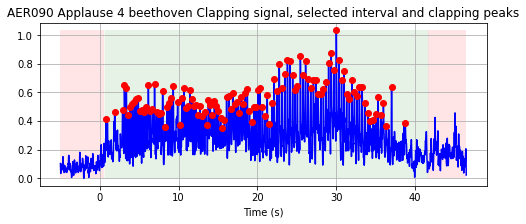

.DS_Store
Applause_3_speech_2_motion.csv
[31, 1.495105336356053, 17, 0.8792164844767952]
[0, 0, 0, nan]
[34, 0.30584835187455506, 11, 0.26222880762183975]
[27, 1.4048316936959138, 9, 0.8659635263193654]
[28, 0.2331817555542994, 24, 0.16346050625071662]
[29, 1.191243891688348, 22, 0.9172715827074943]
[15, 0.5053697993913407, 10, 0.47328028700453856]
[35, 0.20109584156990326, 24, 0.09275295645263032]
[25, 0.379986842722268, 25, 0.28444223397765234]
[16, 0.7387060479134984, 13, 0.6622106268626019]
[33, 0.2900010096260832, 18, 0.17502796650527486]
[29, 0.7000754953514289, 23, 0.4626823310141586]
[12, 0.5542414191252796, 9, 0.6027968748868979]
[31, 0.5949734838893876, 27, 0.42752153754154787]
[19, 0.48998223961922516, 19, 0.32660277209467753]
[36, 0.6436482802733167, 28, 0.34616542733455774]
[0, 0, 0, nan]
[25, 0.6793146011644233, 25, 0.5119213448086077]
[26, 0.21580992895454185, 21, 0.1316439686739514]
[31, 0.19709667429407307, 18, 0.12513752947248638]
[39, 0.49968477699266756, 26, 0.35670

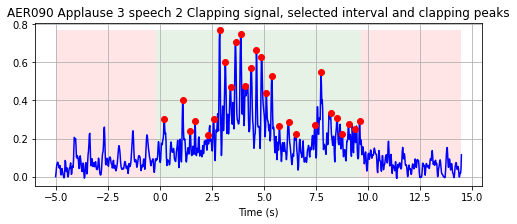

Applause_8_bach_motion.csv
[55, 0.6097280868895135, 47, 0.43174276053433847]
[47, 0.4451396608197053, 39, 0.3316088153824084]
[69, 1.2429003883609584, 68, 0.8349739138630322]
[74, 0.590935834319178, 72, 0.342128807556214]
[74, 0.4549447907885531, 60, 0.27770877681505446]
[60, 1.021588402292063, 53, 0.7031207252119432]
[40, 0.8087544908093998, 40, 0.685350747046151]
[74, 0.7548533469981482, 73, 0.4382973215712439]
[55, 0.5260016903214297, 44, 0.34548832470648533]
[58, 0.9208008403003745, 47, 0.6468184484229834]
[61, 0.36981337438030204, 50, 0.21487744077871057]
[61, 0.8960263873895782, 60, 0.5320060993623916]
[20, 0.6776515965773525, 19, 0.7302011835618027]
[64, 0.6100963320719571, 48, 0.4384536175651841]
[32, 0.3657551955247935, 29, 0.30255062416385164]
[69, 0.5319859106886423, 54, 0.3439381707246272]
[74, 0.47314344133039055, 69, 0.2690519522445834]
[66, 1.072659223040974, 64, 0.6362788170534578]
[59, 0.6160222846637288, 52, 0.4072169788830656]
[56, 0.9311053610614508, 47, 0.618256433

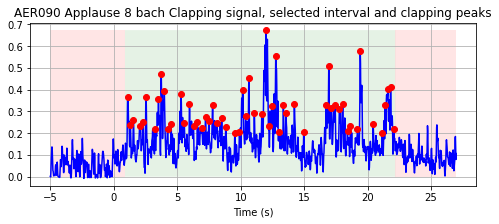

Applause_1_entre_1_motion.csv
[42, 0.5281896941249206, 42, 0.39827628273834914]
[57, 0.2540103036046671, 28, 0.12485230700025224]
[67, 0.9990074179726564, 60, 0.5834187994945625]
[54, 0.5814149299492152, 48, 0.36348792290524945]
[52, 0.275500937916678, 41, 0.1555167042814924]
[51, 1.1153722029046786, 32, 0.8704635038158133]
[41, 1.0014983452614379, 41, 0.7568677344450709]
[54, 0.47345640802191546, 45, 0.3343318367520743]
[45, 0.5158325184530632, 40, 0.3366794197218247]
[46, 1.0990805775920165, 35, 0.8374427100083337]
[54, 0.27000598675282106, 48, 0.11957600059652293]
[46, 0.6774140518484325, 41, 0.4125063245312608]
[18, 0.7056543789918133, 17, 0.6795555656704655]
[44, 0.5446890762236329, 39, 0.3716389149905205]
[56, 0.1850209134830163, 27, 0.11152043561002431]
[56, 0.7722155930537832, 44, 0.5319011106437945]
[0, 0, 0, nan]
[0, 0, 0, nan]
[48, 0.533609357911776, 40, 0.3502800308294344]
[48, 0.7921144901151129, 33, 0.5074540708848074]
[58, 0.4211881312635444, 34, 0.32667167116121393]
[51

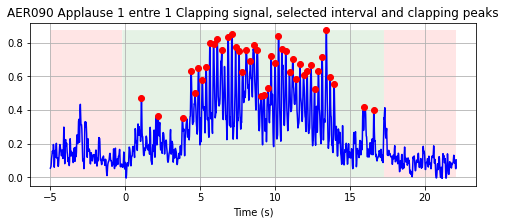

clapping_trimmed
Applause_11_folk_3_motion.csv
[75, 0.4849038685617572, 59, 0.3339059678056853]
[53, 0.5939217558116465, 38, 0.4506961284397655]
[68, 1.1417439229809343, 58, 0.7462281978876607]
[54, 0.9873063997378702, 51, 0.6281790888856342]
[41, 0.35159463350546893, 40, 0.25495341542120936]
[50, 0.8096647130003776, 37, 0.5210009670870454]
[43, 0.8892486743111451, 38, 0.6056673121441095]
[58, 1.0685347788667756, 58, 0.673612044752469]
[55, 0.7984864903744553, 53, 0.5230300363431474]
[61, 0.7200368777091696, 29, 0.5577351659932352]
[34, 0.5367401432234367, 33, 0.4081976712459044]
[50, 0.6567156756736947, 49, 0.3941216811093949]
[43, 1.5602642739817956, 41, 1.2447490741895912]
[49, 0.9606681333529, 42, 0.6925938960143193]
[55, 0.38872391946081264, 37, 0.27177188483175935]
[54, 0.4443880936217322, 44, 0.23494700399886917]
[57, 0.4548515649914594, 55, 0.2712021440993336]
[59, 1.2801813036389178, 59, 0.7969305561124105]
[61, 0.7087362672288887, 58, 0.4584761873527102]
[40, 0.70006547096924

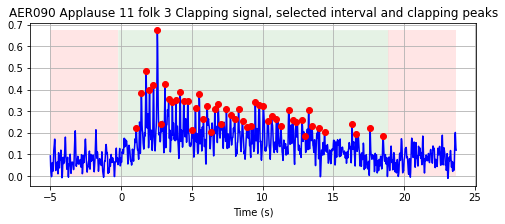

Applause_15_finale_motion.csv
[326, 0.567170454492036, 229, 0.29675759782625016]
[287, 0.9679242113270049, 256, 0.5336185269956457]
[280, 1.4188325452199766, 254, 0.880991459138909]
[317, 1.2172903379381672, 258, 0.6541857199278519]
[324, 0.4301177999501875, 255, 0.22070653378295005]
[299, 1.7238736738755034, 266, 0.9584834680305468]
[313, 1.4536273051695014, 262, 0.7616460757170975]
[317, 1.3594679785600374, 280, 0.6447206706606263]
[292, 0.7706618609612872, 224, 0.43119288650949544]
[312, 1.1252726055883784, 252, 0.6173369498796782]
[328, 0.7411223047054387, 224, 0.42630760367635984]
[315, 0.5731509420154335, 182, 0.3543882157910598]
[330, 1.359254830738911, 146, 1.0643853714307672]
[22, 0.8164198749945376, 17, 0.5572919245964548]
[325, 0.5770073699431639, 240, 0.3165081630360698]
[296, 1.3028960561032208, 248, 0.7807774941978074]
[332, 0.8316088601981566, 271, 0.5426082676264714]
[311, 1.2504113329022721, 277, 0.6005387679022585]
[326, 1.1029713213599734, 278, 0.5609337726361766]
[3

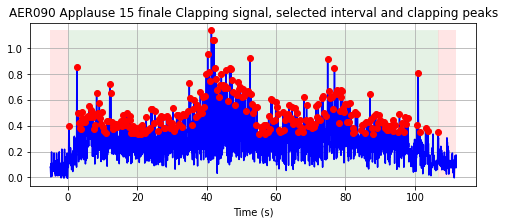

Applause_7_entre_3_motion.csv
[62, 0.4202990191550102, 33, 0.27634757772341634]
[0, 0, 0, nan]
[36, 1.621520269600293, 15, 1.1372085071487308]
[63, 0.8969153585601215, 49, 0.4381095363663046]
[52, 0.28913464823708235, 43, 0.17663346373190675]
[55, 1.215608858609698, 43, 0.7641931110117864]
[38, 0.9784390639043206, 37, 0.737917880712808]
[0, 0, 0, nan]
[44, 0.2986015249503204, 33, 0.2015172374793765]
[0, 0, 0, nan]
[35, 0.3797778643166442, 30, 0.27690794380272626]
[40, 0.8289471370342423, 38, 0.593529561943928]
[43, 0.6969877193297476, 21, 0.6190266238983734]
[60, 0.9470919430032354, 38, 0.6979176484354652]
[4, 0.7188649990130953, 4, 0.2989768468231824]
[0, 0, 0, nan]
[57, 0.4590854419561007, 51, 0.3004488026527928]
[0, 0, 0, nan]
[59, 0.20841143834371542, 28, 0.1279149591118431]
[58, 0.844394231177442, 40, 0.5257893120616748]
[0, 0, 0, nan]
[48, 0.29246883541298047, 39, 0.1909995243107485]
[56, 0.9249095563483117, 45, 0.5011312883324354]
[0, 0, 0, nan]
[59, 0.26536664610776284, 30, 0.1

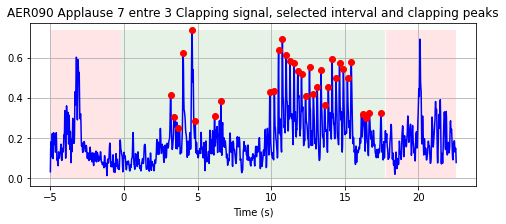

Applause_12_folk_4_motion.csv
[56, 0.5704580806593493, 52, 0.3560738541929304]
[38, 0.7275013425871193, 30, 0.5358076635894048]
[57, 1.1990946214755969, 57, 0.7755761003750753]
[52, 0.5836884525566288, 49, 0.33899117955764796]
[39, 0.3341429625376037, 38, 0.23829874365196202]
[25, 0.4964051297655988, 23, 0.38727882089384236]
[26, 0.6287926141325972, 23, 0.5221340088122606]
[52, 1.1320565155309494, 52, 0.7327069706154062]
[42, 0.5523575935946041, 31, 0.375382785638117]
[45, 0.9375385806960872, 41, 0.642493156842403]
[39, 0.4409125809473792, 21, 0.3609426147695083]
[43, 0.6603384939505061, 39, 0.40827909873831597]
[15, 0.7979755817756233, 14, 0.8835749379103469]
[40, 0.44793532839383365, 28, 0.3165430985739324]
[52, 0.2864011379743947, 18, 0.22882640726056827]
[36, 0.8152095914218651, 35, 0.5995469944125433]
[50, 0.6010911116571289, 50, 0.3793422208668794]
[42, 0.6645024499814607, 41, 0.4995599582484082]
[39, 0.33571070000934866, 27, 0.2411441562990327]
[48, 0.40567897676377246, 29, 0.27

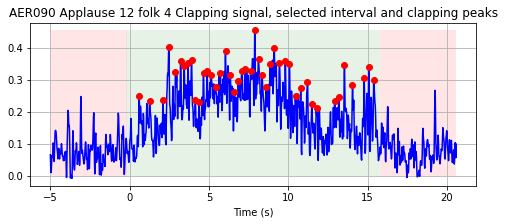

Applause_6_schnittke_motion.csv
[0, 0, 0, nan]
[0, 0, 0, nan]
[210, 1.0244788980711024, 128, 0.6911540380256164]
[199, 0.7520195705004601, 160, 0.36939538091176155]
[175, 0.5618677349553213, 164, 0.2977051633858595]
[164, 1.8150253061467343, 155, 1.0658196508902174]
[170, 0.9028862722193027, 120, 0.5728988820767691]
[194, 0.7258555684561511, 172, 0.3517903013459387]
[160, 0.3782615876480726, 83, 0.27277591037893656]
[174, 1.570611955799342, 129, 1.0492940330689]
[190, 0.4969086381750296, 158, 0.25288600547505946]
[163, 1.1604650590656744, 133, 0.6889032056660074]
[170, 0.7483667706529616, 47, 0.7990853497326655]
[188, 1.0076927580289916, 125, 0.7585501469430039]
[161, 0.9779576432362161, 85, 0.9216840241041568]
[152, 0.47414105358467024, 125, 0.3053741562127467]
[0, 0, 0, nan]
[206, 0.6591111184713581, 114, 0.40144796616031114]
[182, 0.7628993702203656, 106, 0.49738263096991364]
[185, 0.8730515448981309, 147, 0.44784260311938073]
[0, 0, 0, nan]
[170, 0.949398056167134, 169, 0.483931487

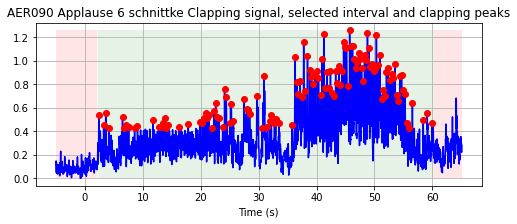

Applause_14_speech_3_motion.csv
[0, 0, 0, 0.07807695168821885]
[0, 0, 0, 0.032725129400989685]
[14, 0.581580226515263, 10, 0.5369568781692697]
[14, 0.29812474553697327, 13, 0.18039894332051895]
[10, 0.26765042149401136, 9, 0.25820106534249654]
[0, 0, 0, 0.07320528065307502]
[13, 0.7023096526878173, 5, 0.7329415549636896]
[15, 0.3636031303506362, 11, 0.2783309644464122]
[17, 0.19471057688236496, 11, 0.09896456000312456]
[9, 0.3137362044438631, 9, 0.30729975133476]
[0, 0, 0, 0.07481045261902958]
[11, 0.24605800776844663, 11, 0.1618116430967832]
[19, 0.13344794259943005, 6, 0.10164329506360673]
[18, 0.17826901463354208, 12, 0.15194642122178684]
[18, 0.37870787022431285, 1, 0.3822420721386946]
[0, 0, 0, 0.020592903105261483]
[15, 0.3094319738141644, 13, 0.19619671432999544]
[13, 0.48974291688537275, 8, 0.44464826818442144]
[0, 0, 0, 0.033891575996398665]
[16, 0.39342305824953694, 13, 0.2751581199798442]
[0, 0, 0, nan]
[0, 0, 0, nan]
[17, 0.2490065954741335, 11, 0.1905423811079595]
[14, 0.3

[14, 0.5089018635559877, 14, 0.46037881225332333]
[16, 0.5665462510745572, 16, 0.40682588974074624]
[28, 0.547667264182317, 17, 0.3250907776106352]
[22, 0.2464910712694725, 21, 0.17825890176769552]
[14, 0.40223688095703497, 11, 0.3444778993812131]
[20, 0.6658151637855279, 18, 0.5361901969709925]
[24, 0.5472634412098976, 22, 0.3786805855254946]
[23, 0.735982428956971, 23, 0.6206010576891842]
[25, 0.5364752792290121, 20, 0.36067127972164775]
[16, 0.1784069674106631, 15, 0.1296938377638474]
[24, 0.5838170404009166, 13, 0.4630301883176486]
[16, 0.381496734563188, 12, 0.30362583833176393]
[18, 0.3752797000644556, 17, 0.28857453171583203]
[20, 0.6390952967625765, 20, 0.5465360524617084]
[22, 0.5354442251960722, 21, 0.40843125444437656]
[18, 0.3341894479227385, 17, 0.26425388132288785]
[24, 0.4252148398273054, 16, 0.3267549921994478]
[29, 0.46238689840868774, 17, 0.36154303200750165]
[24, 0.3155004092897956, 19, 0.2209513983119929]
[23, 0.7645537045195953, 20, 0.5637091919579941]
[24, 0.53234

[43, 0.486596702163005, 24, 0.37725270921251014]
[45, 0.8286414451137512, 45, 0.6097830829280726]
[0, 0, 0, nan]
[39, 0.7669131609177529, 38, 0.556580931861679]
[39, 0.5823264002515692, 36, 0.3911368523883426]
[37, 0.2872058602149694, 24, 0.21608037923180765]
[40, 0.55332584331904, 39, 0.37041219980362294]
[41, 0.7283521080753096, 40, 0.4840517099333451]
[36, 2.4877390265983466, 33, 2.1035404485972267]
[35, 0.6234120843904409, 34, 0.44823608746925564]
[45, 0.8675979651939781, 44, 0.5482455526034391]
[32, 0.6917505474921031, 27, 0.5357496723779116]
[34, 0.5693614356547445, 19, 0.4045874910585794]
[0, 0, 0, 0.03727210125711656]
[34, 1.0340346606876252, 34, 0.774320013109578]
[45, 0.4254788156643893, 27, 0.29147556474037317]
[37, 0.6491146380681313, 35, 0.477783480111719]
[38, 0.8305153747396051, 32, 0.5855829883274463]
[37, 0.5226746784487365, 36, 0.3832915502156048]
[44, 0.24036910737688472, 39, 0.14906334364608587]
[33, 0.5975652165365877, 25, 0.4801574626536001]
[0, 0, 0, nan]
[29, 0.

In [130]:

extend_seg = 5 # five seconds was the extension given to the segments being evaluated
extend_ind = 5*fs # segmentation extension, in number of samples
extend = 10 * 0.02 # extending the evaluation windows for peak picking by 0.2 s in samples
std_thr = 0.08

for f in list_files:
    print(f)
    # check if a csv file
    if not f.endswith('.csv'):
        continue
    # read data
    df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
    df_motion.index = df_motion.index/1000
    df_ev = df_motion.copy()
    seg_len=len(df_motion)

    # create dataframes for each output csv files
    df_trimmed = pd.DataFrame(index=df_ev.index)
    df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
    df_rms = pd.DataFrame(columns=df_ev.columns)

    thr_list = []
    # run through the participants
    for i, col in enumerate(df_ev.columns):
        # extract the rms of this participants motion through segment intervals (clapping +/- 5 s)
        rms = rms_signal(df_ev[col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
        df_rms[col] = rms['rms']
        
        std = np.std(df_ev[col])
        
        # establish a threshold value for signal rms values where peaks will be evaulated and counted.
        thr = rms.mean()[0] + std*0.35
        
        # if the motion doesn't seem to include clapping (no signal, signal very low), then ignore. 
        thr = 0 if np.isnan(thr) else thr
        thr = 0 if std<=std_thr else thr
        thr_list.append(thr) # keep track of which have 

        # in out pins
        # Extends the window for evaluting the peaks by 10 timestamps at both ends (0.2 s)
        # else, whole signal to NaN.
        if not (thr == 0):
            in_  = max(df_ev[df_ev[col]>thr][col].index.values[0],0) - extend
            out_ = min(df_ev[df_ev[col]>thr][col].index.values[-1],df_ev.index[-1]-extend_seg) + extend
        else:
            in_  = 0
            out_ = 0
        df_ev.loc[:in_,col] = np.nan
        df_ev.loc[out_:,col] = np.nan

        # use signal library's find_peaks to pull out peaks in jerk corresponding to clap impacts
        peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]

        #trim peaks based on their height too.
        s_plot = df_ev[col].iloc[peak_index_list]
        s_plot = s_plot[s_plot>thr]
        print([len(peak_index_list),thr,len(s_plot),std])
        
        # signal based on first and last claps
        df_peaks.loc[:,col] = np.nan
        if not s_plot.notna().sum() == 0:
            if s_plot.notna().sum()/df_motion.index[-1] <4: # if the peaks recorded are not faster than 4 Hz
                # define region of applause based on acceptable peaks found in motion signal (with 0.2 s extension)
                in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
                out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
    #             in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
    #             out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
                df_ev.loc[:in_peak,col] = np.nan
                df_ev.loc[out_peak:,col] = np.nan

                df_peaks.loc[s_plot.index,col] = s_plot.values

        # write to df
        df_trimmed[col] = df_ev[col].values

    csv_peaks_output_dir = DIR + '/clapping_peaks/'
    df_peaks_save = df_peaks.copy()
    df_peaks_save.index.name = 'index'
    df_peaks_save.to_csv(csv_peaks_output_dir + f.replace('motion', 'peaks'))


    # plot the last participant's claps 
    if df_peaks.loc[:,col].sum()>0:
        plt.figure(figsize = [8,3])
#         i = -1 # participant idx
        plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

        plt.title(col + ' ' + ' '.join(f.split('_')[:-1]) + ' Clapping signal, selected interval and clapping peaks' )
        plt.xlabel('Time (s)')
        plt.grid()
        plt.savefig('./plots/clapping_'+col + '_' + '_'.join(f.split('_')[:-1]) +'.png',bbox_inches = 'tight',dpi = 300)
        plt.show()


# Old evals

Code to do pretty much the same but with different time stamp treatment and documentation.

[37, 0.3040188958508938, 21, 0.18010617159783612]
[0, 0, 0, nan]
[0, 0, 0, 0.0482993323336088]
[34, 0.6062297387603006, 21, 0.3345851682782523]
[21, 0.34746370783870734, 19, 0.2321990073442047]
[0, 0, 0, 0.040749280063560545]
[20, 0.9367879107563516, 20, 0.6860984018277176]
[39, 0.9686514170101452, 13, 0.5098537061126477]
[0, 0, 0, 0.030067887536101862]
[40, 0.18761136621424496, 7, 0.17612682418090372]
[26, 0.3091542328875255, 9, 0.2800339203577544]
[24, 0.7915078946057706, 21, 0.45714537337732497]
[22, 0.8797931123825369, 8, 0.9908432986493751]
[35, 0.1422905246368913, 15, 0.08770366308639807]
[0, 0, 0, 0.05533260481627043]
[28, 1.1419326436097683, 6, 0.9381796825478459]
[0, 0, 0, nan]
[0, 0, 0, 0.07523694853121538]
[0, 0, 0, 0.03968559357096071]
[28, 0.20420050324422703, 17, 0.11688241233601643]
[0, 0, 0, 0.06307354268307233]
[25, 0.7883556220464638, 10, 0.7166060286308704]
[0, 0, 0, 0.05369634269696732]
[12, 0.2124620125974201, 11, 0.15904056847371287]
[20, 0.805674215415841, 19, 0.

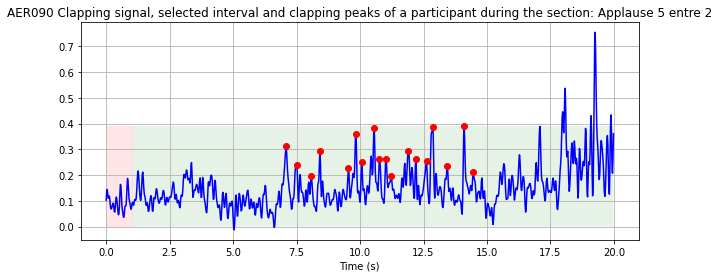

[117, 0.5965215322802444, 107, 0.32736060832610986]
[0, 0, 0, nan]
[113, 1.2557452931522934, 113, 0.7788990732065116]
[127, 0.800183825811676, 115, 0.40062993280728365]
[103, 0.39768667243919265, 86, 0.22473768713007652]
[117, 1.9964198664602106, 116, 1.2076898031755814]
[85, 1.0918637802307622, 82, 0.684638273512308]
[96, 0.6371682703006214, 72, 0.39897064219582656]
[126, 0.581468916461464, 74, 0.32662745016425176]
[130, 1.912928514863934, 78, 1.5216757186598646]
[123, 0.3619438380273445, 79, 0.17857715051995623]
[125, 0.8171037002033443, 71, 0.4469999237579537]
[49, 0.8742717129544181, 28, 0.9641884850614747]
[99, 0.7428613388528726, 95, 0.41509240681215376]
[119, 0.5914627486097772, 101, 0.33996491224225467]
[123, 0.49012622008487944, 87, 0.27830634681133937]
[0, 0, 0, nan]
[135, 0.5323690754693757, 67, 0.328526282729804]
[130, 1.2291284432693947, 112, 0.6366343058900623]
[137, 0.6485060537211013, 55, 0.4259244472799344]
[143, 0.5300136140791742, 82, 0.3226954509891805]
[101, 0.7523

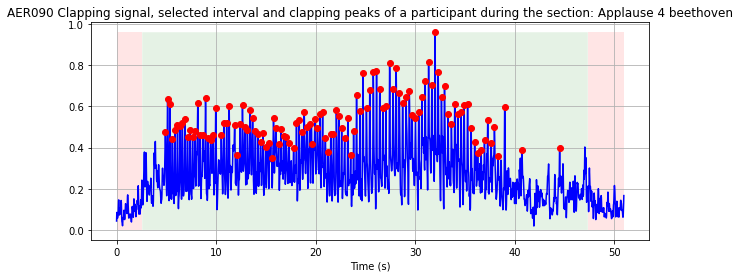

[23, 1.339206757849296, 9, 0.8756864250005493]
[0, 0, 0, nan]
[32, 0.31412321880213334, 6, 0.25931312699332454]
[31, 1.2808139027427143, 12, 0.8763167827292667]
[17, 0.2316243530112555, 16, 0.1630784057604067]
[19, 1.148086444224148, 19, 0.9304504304052469]
[10, 0.5156752926370514, 5, 0.47602675113725784]
[35, 0.19052914973234225, 16, 0.0904423918238899]
[19, 0.3818052586385558, 19, 0.28084685280452054]
[12, 0.7527629510173427, 12, 0.6602794722991108]
[20, 0.2888972893967117, 17, 0.17335412218184612]
[20, 0.6624557690323799, 19, 0.47110426307333436]
[8, 0.557391615179123, 6, 0.6043838223284193]
[40, 0.6113528886880756, 27, 0.4178482933869463]
[28, 0.5407318839423033, 21, 0.33242140541959303]
[36, 0.6729135014242973, 26, 0.34927488093304115]
[0, 0, 0, nan]
[18, 0.6754625885210646, 18, 0.5186560675619261]
[21, 0.21566049976225715, 18, 0.12793293218535978]
[31, 0.212116467566256, 10, 0.1255791832045514]
[38, 0.5463132428811628, 22, 0.39514465310241026]
[24, 0.5237591027031008, 23, 0.34939

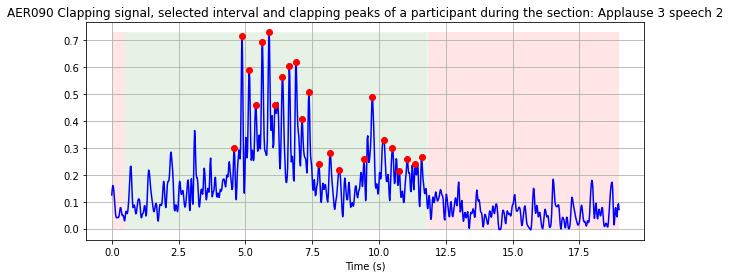

[52, 0.605714108565911, 46, 0.4271499688069186]
[47, 0.4411114351375985, 39, 0.32819387875284844]
[66, 1.2443402607800849, 65, 0.8167512273008037]
[70, 0.5858693642544668, 66, 0.32719029918588294]
[67, 0.45279224925435124, 53, 0.2674970821393389]
[60, 1.0069499836764837, 53, 0.6869332988962525]
[38, 0.809557451950641, 38, 0.6744443297376789]
[72, 0.7564855139082611, 71, 0.42437665493579174]
[48, 0.5228707681786934, 41, 0.3379384628679868]
[54, 0.9177758156382481, 47, 0.6321174620103694]
[72, 0.3843349787806955, 50, 0.20907594344939262]
[56, 0.8897127036774874, 56, 0.5114460670523704]
[20, 0.6795757890507228, 19, 0.7253590337780575]
[60, 0.6087295773303962, 45, 0.4298312921503622]
[31, 0.3635011705451202, 28, 0.2987294037577131]
[74, 0.54988398356509, 48, 0.3334601178589279]
[78, 0.4757222318989104, 65, 0.25898603814255616]
[62, 1.065971106683268, 60, 0.6164649434535331]
[59, 0.6049380941395918, 52, 0.3871935484593624]
[72, 0.9261148264269061, 45, 0.6050455743289961]
[0, 0, 0, nan]
[75,

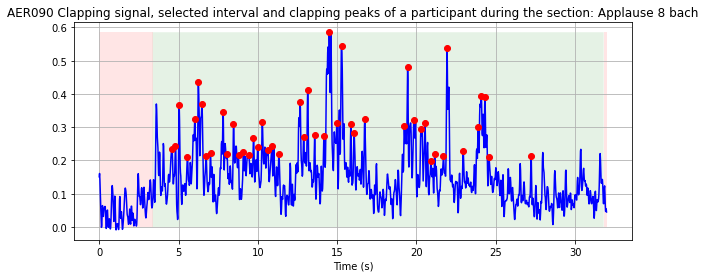

[40, 0.5376144065941691, 40, 0.39551528355636795]
[53, 0.24105891911219812, 24, 0.11998795708105832]
[58, 0.978762980262653, 54, 0.5841388414785501]
[45, 0.5885013918473042, 45, 0.3542295854371295]
[57, 0.28008201397515115, 43, 0.15119339128673862]
[39, 1.0929020019956648, 32, 0.8530335174508419]
[36, 1.0229850993615934, 36, 0.7590375031257327]
[44, 0.4747123834592699, 43, 0.3301852238895035]
[37, 0.5245365959689409, 35, 0.329368199948071]
[38, 1.0819820608619615, 34, 0.7959561761953551]
[48, 0.260576033501568, 44, 0.11897197682265465]
[48, 0.6845256092252354, 41, 0.4006534437963857]
[17, 0.7218647294766822, 17, 0.684690341266533]
[42, 0.5557285036003496, 39, 0.36763777122766106]
[56, 0.185683253122022, 20, 0.11279197783862176]
[51, 0.7678190358875079, 40, 0.5269761017657606]
[0, 0, 0, nan]
[0, 0, 0, nan]
[46, 0.5324148267498763, 39, 0.33684548623651966]
[51, 0.8015170168652832, 32, 0.5053020705013822]
[46, 0.42169176879075304, 30, 0.3278966964453911]
[42, 0.4181070402368332, 40, 0.270

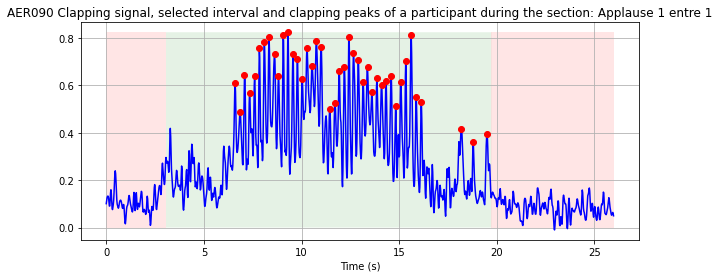

[65, 0.47650408514491394, 53, 0.3200631783481571]
[46, 0.581256678121245, 31, 0.4449047326544601]
[67, 1.1198360853737577, 55, 0.7326560352408025]
[46, 0.9586245854424759, 45, 0.6076592886679149]
[34, 0.34389413944766445, 34, 0.24882059681781835]
[55, 0.7896748119382907, 38, 0.5048881072672546]
[37, 0.8695200547538648, 33, 0.5917680533949843]
[54, 1.0442347098968972, 54, 0.6581857359133287]
[46, 0.7803965037578456, 45, 0.5098866488312815]
[50, 0.703300641725933, 23, 0.5462199685087027]
[32, 0.5288193446226663, 32, 0.40336979215073027]
[45, 0.6377519796303773, 45, 0.37887262621783635]
[43, 1.535465025669824, 41, 1.229263340502042]
[44, 0.940686923217763, 41, 0.6770135949551032]
[53, 0.37790141798168, 33, 0.26582561091046053]
[46, 0.4300771515314664, 38, 0.23179304934230174]
[53, 0.4492313536926066, 52, 0.26606418818195027]
[54, 1.2427919474643279, 54, 0.776150821478894]
[56, 0.6808657094346318, 52, 0.4345750401402344]
[27, 0.6866406391019094, 25, 0.4813301991400154]
[0, 0, 0, nan]
[0, 0

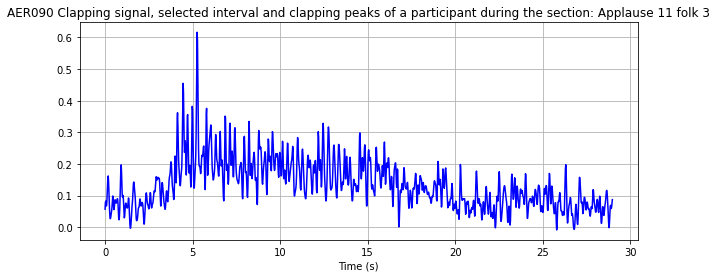

[329, 0.563940469524563, 215, 0.28470388469901003]
[273, 0.9590602944332034, 249, 0.5247936020057989]
[269, 1.406856029999778, 244, 0.8724420933184309]
[319, 1.221810969577959, 248, 0.6308603315245391]
[322, 0.42461475245408997, 246, 0.21455100036985458]
[291, 1.7113795220548083, 264, 0.9420304672480797]
[314, 1.44258689077535, 256, 0.7501302059356543]
[306, 1.3465866438673604, 269, 0.623171735816018]
[277, 0.7601558958114034, 211, 0.4194042668954047]
[301, 1.1127480145083601, 247, 0.602949692228921]
[323, 0.7363089877821484, 221, 0.4199422509597534]
[297, 0.5669738419995903, 174, 0.3474596013723174]
[330, 1.3569505893191585, 146, 1.0511175402272852]
[17, 0.9509417676120167, 11, 0.5561146704402976]
[311, 0.5711220322962202, 233, 0.3093005084916244]
[289, 1.2807231760877067, 237, 0.756987119841161]
[326, 0.8376719533886238, 251, 0.5238462690791988]
[297, 1.2353265992991878, 260, 0.5850849292310959]
[329, 1.0814729710651743, 268, 0.5213833945096187]
[329, 0.9943284510604242, 220, 0.47390

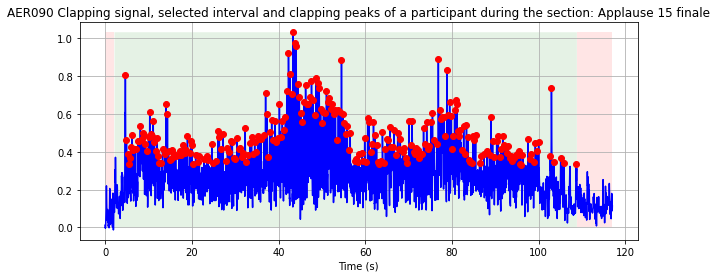

[50, 0.4137090672302543, 30, 0.28407884841992603]
[0, 0, 0, nan]
[40, 1.789603938581518, 12, 1.2118464088166494]
[58, 0.8686858013520309, 51, 0.43546185570518464]
[39, 0.2916615598522995, 39, 0.17794248356814032]
[42, 1.1734521269253557, 42, 0.7840307218836644]
[34, 1.0140985783144032, 34, 0.7448197180664756]
[0, 0, 0, nan]
[38, 0.30882328142578963, 28, 0.20023828625403825]
[0, 0, 0, nan]
[30, 0.39380682596197386, 29, 0.2790570904070539]
[39, 0.8574359017967, 38, 0.5939403659245698]
[21, 0.577852157956595, 21, 0.5401831355467037]
[48, 0.9530258284384849, 36, 0.7077150682141893]
[11, 0.7140492900905313, 9, 0.3266426867431682]
[0, 0, 0, nan]
[55, 0.47604710512587434, 45, 0.2966024320239729]
[0, 0, 0, nan]
[55, 0.21115989267246948, 24, 0.12383618697052849]
[46, 0.8579814777541312, 37, 0.5303362735469448]
[0, 0, 0, nan]
[50, 0.31957609102903894, 33, 0.20015183100746242]
[43, 0.9280448874135279, 43, 0.5127078120220584]
[0, 0, 0, nan]
[57, 0.29540857608716886, 26, 0.1789894637662659]
[0, 0, 

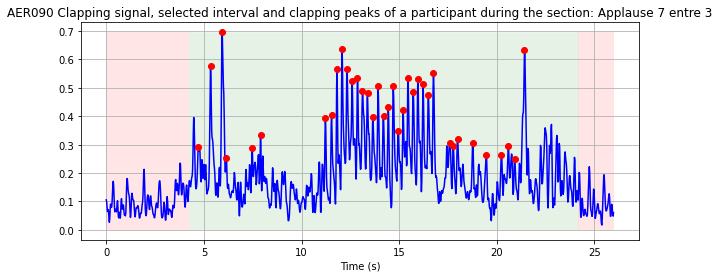

[47, 0.5742369675253544, 40, 0.3450295080222774]
[31, 0.7287275702184834, 23, 0.5307966853162893]
[49, 1.1990790102227755, 49, 0.7590142520555901]
[50, 0.5955452841027633, 44, 0.32655977528248864]
[30, 0.33674246243798966, 30, 0.23314044391299352]
[20, 0.4960376880948793, 20, 0.38137030491819823]
[17, 0.6320829991257331, 17, 0.5135080907778209]
[45, 1.132972678976019, 45, 0.6936991353196508]
[32, 0.5567529025177591, 25, 0.35990080223057114]
[35, 0.9369680707703558, 33, 0.6290044569936425]
[24, 0.4421052419578339, 20, 0.3577757037402588]
[33, 0.6705569721477352, 30, 0.38167127953902275]
[16, 0.8049450066830595, 14, 0.8852337769902007]
[32, 0.44538484923367616, 28, 0.31337637383967104]
[48, 0.29023878503101364, 17, 0.22460167398021824]
[30, 0.8077222933070123, 30, 0.5804073498937321]
[43, 0.6083489573120566, 42, 0.37185091216826544]
[32, 0.6677303281859146, 32, 0.4922358050297867]
[36, 0.32999725241931477, 25, 0.23271550417734715]
[35, 0.40486076400307147, 18, 0.271681769903425]
[0, 0, 0

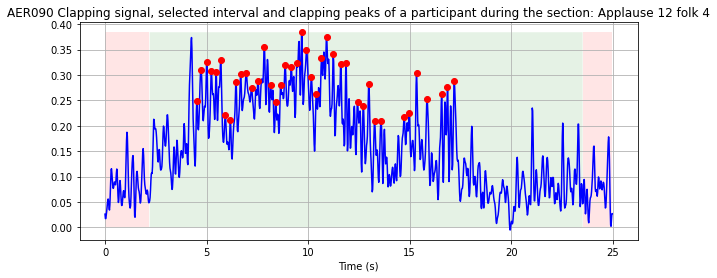

[0, 0, 0, nan]
[0, 0, 0, nan]
[214, 1.0279999707069745, 125, 0.6815906859061532]
[204, 0.7581723183274813, 149, 0.34969002504265406]
[183, 0.5582944653516688, 164, 0.286952500886133]
[170, 1.8412834203298534, 154, 1.0351715921739462]
[165, 0.8981429790601, 114, 0.5663234802522253]
[185, 0.7216738801713637, 165, 0.3352355362350718]
[149, 0.374567200615939, 77, 0.2677593714321166]
[168, 1.5636731963956376, 127, 1.03402670519815]
[188, 0.4944412396959808, 155, 0.2471168675090108]
[158, 1.15328086523446, 133, 0.673424740162593]
[161, 0.7433822411416404, 45, 0.7892143944630047]
[192, 1.03834940104026, 121, 0.7390673460908362]
[165, 0.9643659533454114, 87, 0.892493751700731]
[153, 0.4712768874937763, 123, 0.2992274754526825]
[0, 0, 0, nan]
[204, 0.6564991983596298, 109, 0.391135937266584]
[177, 0.7500038953101607, 101, 0.4767233497394198]
[195, 0.8649832865868026, 141, 0.42634882233775895]
[0, 0, 0, nan]
[169, 0.9405890668881709, 169, 0.4637279777519118]
[189, 0.6255622279033236, 130, 0.3794

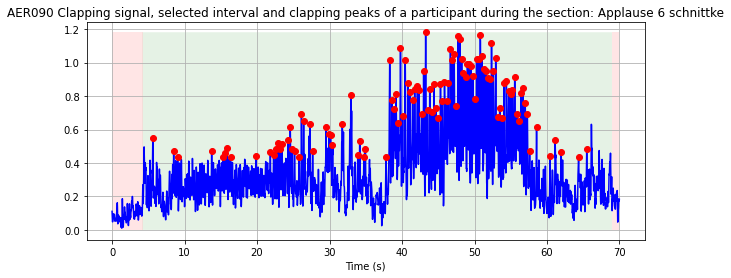

[0, 0, 0, 0.07548874561450722]
[0, 0, 0, 0.028010110355838325]
[13, 0.5960661771208191, 2, 0.5156204862987256]
[17, 0.35372215790004435, 13, 0.18334345209288025]
[0, 0.2707424565845979, 0, 0.2561486394516702]
[0, 0, 0, 0.07167044315550586]
[0, 0.24405968614716939, 0, 0.26849642279571984]
[15, 0.3800521379219042, 3, 0.2614839052878444]
[17, 0.18401717466353348, 6, 0.10123856013813033]
[0, 0.2763508043656492, 0, 0.3111129291186487]
[0, 0, 0, 0.07539788249302856]
[15, 0.2841133191182189, 7, 0.1592617106674398]
[18, 0.13814023507581802, 3, 0.10046379568090827]
[16, 0.1783082088255381, 1, 0.1521385157459107]
[12, 0.20055801849876215, 5, 0.09491309866828403]
[0, 0, 0, 0.01878346155956321]
[15, 0.33976343028683315, 15, 0.1849894462804198]
[10, 0.48530554480390486, 1, 0.44465518147571265]
[0, 0, 0, 0.030096334429609503]
[15, 0.36195753156691163, 1, 0.277140410997532]
[0, 0, 0, nan]
[0, 0, 0, nan]
[14, 0.24699716668804936, 0, 0.19253040276914063]
[16, 0.33153031566213903, 4, 0.25966464071872686

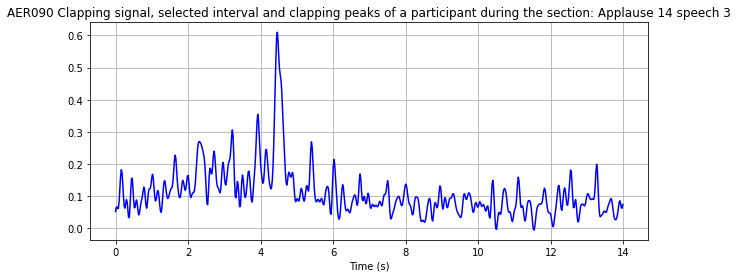

[49, 0.45917312924192877, 49, 0.27860487442465715]
[30, 0.4473286534616555, 30, 0.34384625285723286]
[51, 1.2474381456424493, 51, 0.8375871944010347]
[59, 0.5540632828925612, 56, 0.29302975717009355]
[37, 0.39046850623886264, 37, 0.26855335176700207]
[34, 0.6519785826175579, 33, 0.4842728682897992]
[26, 0.6981929666423629, 25, 0.5859958352247296]
[42, 0.7789344009708943, 42, 0.5110047731060202]
[33, 0.47851830270767914, 31, 0.3520008744654889]
[45, 0.9447414321242646, 36, 0.641609758772729]
[42, 0.3882542490365173, 41, 0.2185960544696092]
[42, 0.6175802716373839, 33, 0.4021392571750952]
[38, 0.7023272406859327, 13, 0.807546218675349]
[45, 0.9934187530438379, 43, 0.7769284419195348]
[26, 0.2693566537114106, 24, 0.20642858812633008]
[55, 0.574592547029104, 33, 0.37568445643238907]
[39, 0.44886468170902794, 37, 0.30339676696356604]
[62, 0.6330879544107519, 43, 0.4153290511512213]
[35, 0.46887856050622934, 33, 0.3313961061652356]
[47, 0.44619785511390775, 29, 0.28828935585227755]
[0, 0, 0,

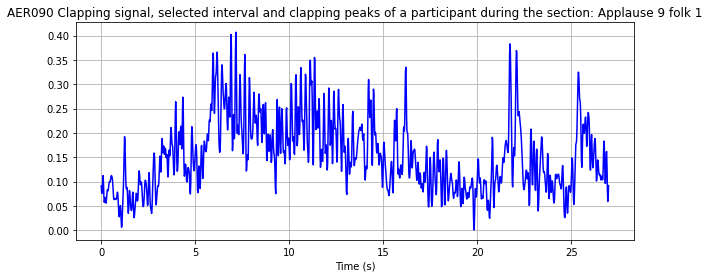

[26, 0.4824484292797156, 12, 0.3372507030625516]
[0, 0, 0, nan]
[19, 0.8336044386009789, 19, 0.6652378555692477]
[20, 0.4798029133130935, 20, 0.33636278801603253]
[14, 0.34469251243113586, 14, 0.2131534879792531]
[13, 0.45378232426650567, 13, 0.36806088372755147]
[13, 0.6060439177164721, 12, 0.5253388594360824]
[24, 0.15742627136413515, 16, 0.09928267645655006]
[14, 0.466454739019591, 13, 0.35678823526226544]
[13, 1.039416457207807, 13, 0.8724128576076123]
[16, 0.23155435762025994, 12, 0.1585442880767847]
[12, 0.360667164531731, 12, 0.28170613072496936]
[13, 0.6841467377857442, 12, 0.6993865524915326]
[17, 0.2202336801808087, 17, 0.14977484359733162]
[20, 0.36383457960489507, 4, 0.3014784541905363]
[18, 0.6561903749355975, 18, 0.4931423796717787]
[0, 0, 0, nan]
[0, 0, 0, nan]
[13, 0.40149488540481093, 12, 0.2789217874777541]
[23, 0.3747828940604794, 8, 0.21045628241174608]
[29, 0.20434228317376354, 15, 0.12379710329744203]
[18, 0.2923601097972426, 12, 0.21329968940534005]
[20, 0.498553

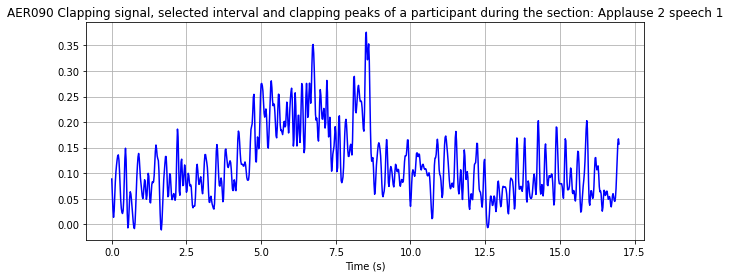

[62, 0.3850397699039231, 56, 0.2510878248828943]
[55, 0.4931787804018365, 47, 0.3143819435735407]
[56, 0.9577399363895895, 47, 0.6841385500548645]
[55, 0.8103652232752714, 55, 0.4871192611985717]
[45, 0.4335972366129923, 43, 0.295177218849971]
[22, 0.5814340595441818, 22, 0.5266774296496111]
[19, 0.8274998255646059, 19, 0.7447203960931926]
[56, 0.626526416850492, 43, 0.4083999034416881]
[39, 0.43852721301119657, 36, 0.3066098484733687]
[54, 0.8424447088024114, 37, 0.5630841146873163]
[42, 0.4122700784522727, 42, 0.25474798045810965]
[38, 0.5550408938027429, 37, 0.36168349619626416]
[47, 0.7368767091648811, 11, 0.7943866719963509]
[44, 0.7492719456750402, 42, 0.5053722744055417]
[49, 0.3172789370146232, 41, 0.2097575952580155]
[45, 0.5073328141544677, 42, 0.3451238866768981]
[55, 0.44505902744548453, 27, 0.31870296952220456]
[55, 1.0297111984304008, 55, 0.6613856421296777]
[52, 0.43315400225323, 35, 0.305708365480549]
[49, 0.6635823694203428, 43, 0.42766598356167934]
[0, 0, 0, nan]
[0, 

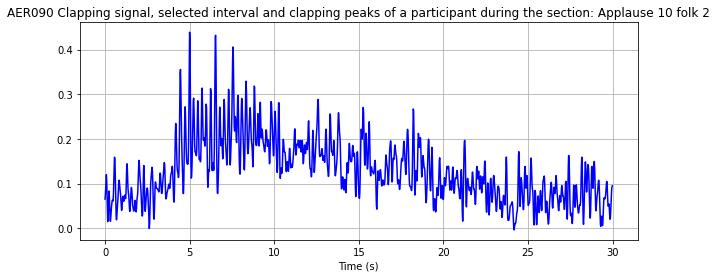

[38, 0.5742508269629477, 38, 0.3594889888796199]
[21, 0.49385089003886457, 21, 0.40866080584803266]
[37, 1.1337556252542391, 37, 0.8121472740088148]
[32, 0.7747904698347676, 32, 0.49928912603542447]
[26, 0.30619858451245935, 26, 0.20118662656714426]
[22, 0.4700855528815977, 21, 0.3808665646502378]
[43, 1.2155319053914437, 25, 0.8044719985504709]
[31, 0.8722779391446791, 31, 0.6163112111731597]
[28, 0.6383079853069591, 28, 0.4285454164216098]
[29, 0.8737800690488252, 29, 0.6435067080798859]
[27, 0.383501994100195, 19, 0.3120684692694788]
[27, 0.5296257484319611, 25, 0.3602624494393434]
[21, 1.3062914629286313, 20, 1.3213373338833592]
[36, 0.7597120757867997, 34, 0.5342476855304622]
[34, 1.1196345927999056, 20, 0.9052491394290135]
[32, 0.6520113037610076, 23, 0.5644583275064072]
[36, 0.4981933658470985, 36, 0.3271574751149851]
[22, 0.5408145438437748, 22, 0.36544088038357364]
[24, 0.4432357256040086, 22, 0.30437214642205795]
[40, 0.7187863408190946, 27, 0.4351015420182817]
[0, 0, 0, nan]

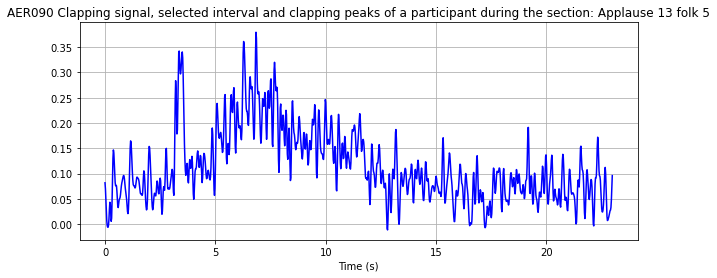

In [80]:
# old threshold from clapping interval in full. This helps avoid the mid bumps
# for every clapping event
for f in list_files:
    # check if a csv file
    if not f.endswith('.csv'):
        continue

    # read data
    df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
    df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
    df_ev = df_motion.copy()
    extend_ind = 4.5*fs # extended clapping range by 4.5 s from fuzzy onset (s) (measure taken from 5 s before)
    #extend_ind = 0
    seg_len=len(df_motion)


    # create csv files
    df_trimmed = pd.DataFrame(index=df_ev.index)
    df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
    df_rms = pd.DataFrame(columns=df_ev.columns)

    thr_list = []

    # for every participant
    for i, col in enumerate(df_ev.columns):
        # thresholding from motion including clapping interval
        rms = rms_signal(df_ev.loc[:,col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
        std = np.std(df_ev[col])
        thr = rms.mean()[0] + std*0.35
        thr = 0 if np.isnan(thr) else thr
        std_thr = 0.08 
        # discard if std of signal is below std_thr
        thr = 0 if std<=std_thr else thr
        thr_list.append(thr)

        # save rms
        df_rms[col] = rms['rms']

        # in out pins 
        # set motion measure to nan for range:
#             1. outside of interest zone
#             2. below threshold (adapted rms)
        # Extends the window 10 timestamps at both ends
        extend = 10 * 0.02 # 0.2 s
        if not (thr == 0):
            in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
            out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
        else:
            in_  = 0
            out_ = 0
        df_ev.loc[:in_,col] = np.nan
        df_ev.loc[out_:,col] = np.nan

        # peaks
        peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
        
        # cut the peaks outside of the clapping range (not peaks because not audible in audio)
        peak_index_list=peak_index_list[peak_index_list>=extend_ind]
        peak_index_list=peak_index_list[peak_index_list<=seg_len-extend_ind]
        
        # cut the peaks that do not exceed the rms threshold
        s_plot = df_ev[col].iloc[peak_index_list]
        s_plot = s_plot[s_plot>thr]
        print([len(peak_index_list),thr,len(s_plot),std])

        # trim first and last peaks, + extend
        # Extends the window 10 timestamps at both ends after trimming the
        # signal based on first and last claps
        df_peaks.loc[:,col] = np.nan
        
        if not s_plot.notna().sum() == 0:
            if s_plot.notna().sum()/df_motion.index[-1]<4: # last catch on extrem noise. Clapping should never be so numerous
                in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
                out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
                in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
                out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
                df_ev.loc[:in_peak,col] = np.nan
                df_ev.loc[out_peak:,col] = np.nan
                
                df_peaks.loc[s_plot.index,col] = s_plot.values

        # write to df
        df_trimmed[col] = df_ev[col].values
        

        # end devices loop

    # save as csv files
    csv_trimmed_output_dir = DIR + '/clapping_trimmed/'
    df_trimmed_save = df_trimmed.copy()
    df_trimmed_save.index.name = 'index'
    df_trimmed_save.index = pd.date_range(0, periods=len(df_trimmed_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_trimmed_save.to_csv(csv_trimmed_output_dir + f.replace('motion', 'trimmed'))

    csv_peaks_output_dir = DIR + '/clapping_peaks/'
    df_peaks_save = df_peaks.copy()
    df_peaks_save.index.name = 'index'
    df_peaks_save.index = pd.date_range(0, periods=len(df_peaks_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_peaks_save.to_csv(csv_peaks_output_dir + f.replace('motion', 'peaks'))

    #   # plot
    plt.figure(figsize = [10,4])
    
#     i = -1 # participant idx
    plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

    if df_peaks.loc[:,col].sum()>0:
        
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

    plt.title(col + ' Clapping signal, selected interval and clapping peaks of a participant during the section: ' + ' '.join(f.split('_')[:-1]))
    plt.xlabel('Time (s)')
    plt.grid()
    plt.show()
  # end clappings loop

    csv_trimmed_output_dir, os.listdir(csv_trimmed_output_dir), csv_peaks_output_dir, os.listdir(csv_peaks_output_dir)

[41, 0.3651590467044261, 20, 0.18010617159783612]
[0, 0, 0, nan]
[0, 0, 0, 0.0482993323336088]
[21, 0.9250722684457654, 14, 0.3345851682782523]
[23, 0.34288971601708146, 21, 0.2321990073442047]
[0, 0, 0, 0.040749280063560545]
[20, 1.7070392626166886, 20, 0.6860984018277176]
[41, 0.7907357058335212, 20, 0.5098537061126477]
[0, 0, 0, 0.030067887536101862]
[11, 0.2560467015108917, 5, 0.17612682418090372]
[28, 0.31033254850591885, 10, 0.2800339203577544]
[26, 1.168758865191014, 19, 0.45714537337732497]
[24, 0.6658512138718417, 8, 0.9908432986493751]
[38, 0.11843582547969923, 20, 0.08770366308639807]
[19, 0.17414662300084494, 5, 0.05533260481627043]
[28, 1.372392033280368, 3, 0.9381796825478459]
[0, 0, 0, nan]
[41, 0.17691972790583488, 15, 0.07523694853121538]
[0, 0, 0, 0.03968559357096071]
[38, 0.18950949268625938, 19, 0.11688241233601643]
[41, 0.1053416683290298, 7, 0.06307354268307233]
[27, 0.6833585573755553, 13, 0.7166060286308704]
[36, 0.1367099542485251, 13, 0.05369634269696732]
[13,

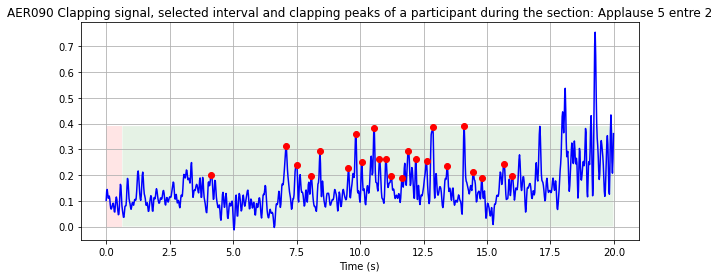

[120, 0.5978167712391594, 110, 0.32736060832610986]
[0, 0, 0, nan]
[115, 1.3814262710537597, 115, 0.7788990732065116]
[129, 0.8037016303190341, 116, 0.40062993280728365]
[105, 0.54423190187583, 72, 0.22473768713007652]
[118, 1.0734340420934596, 117, 1.2076898031755814]
[87, 0.9753326015532584, 83, 0.684638273512308]
[87, 0.7002962022735999, 69, 0.39897064219582656]
[112, 0.6792146120174429, 63, 0.32662745016425176]
[134, 2.34684923322408, 76, 1.5216757186598646]
[126, 0.22907263134293798, 93, 0.17857715051995623]
[128, 0.8159303157440576, 73, 0.4469999237579537]
[49, 0.5635251682908998, 29, 0.9641884850614747]
[131, 0.6072433701211983, 98, 0.41509240681215376]
[137, 0.24235040994898965, 120, 0.33996491224225467]
[130, 0.3656700796163851, 105, 0.27830634681133937]
[0, 0, 0, nan]
[68, 0.9281696427068467, 40, 0.328526282729804]
[132, 1.0267584390496807, 121, 0.6366343058900623]
[90, 0.900538273403348, 44, 0.4259244472799344]
[60, 0.9497681766636248, 32, 0.3226954509891805]
[121, 0.4629907

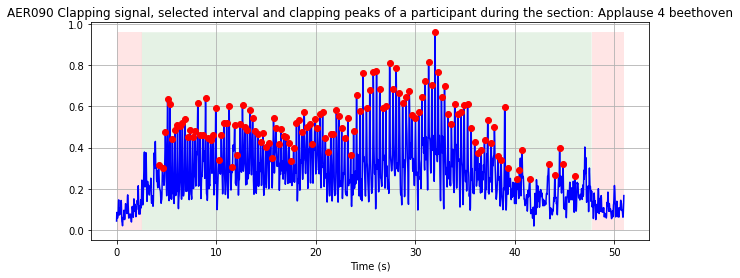

[24, 2.1813884152138305, 6, 0.8756864250005493]
[0, 0, 0, nan]
[36, 0.3383844792679621, 6, 0.25931312699332454]
[32, 1.6259547395528742, 11, 0.8763167827292667]
[19, 0.3389293577377357, 16, 0.1630784057604067]
[20, 1.2556833821619109, 20, 0.9304504304052469]
[12, 0.8059703885184137, 7, 0.47602675113725784]
[21, 0.2786355559237298, 8, 0.0904423918238899]
[20, 0.3792739549217573, 20, 0.28084685280452054]
[13, 0.6929741916430263, 13, 0.6602794722991108]
[21, 0.3004341885264092, 17, 0.17335412218184612]
[21, 0.608304508283464, 20, 0.47110426307333436]
[13, 0.4329622319760396, 9, 0.6043838223284193]
[43, 0.476338721216483, 27, 0.4178482933869463]
[36, 0.27154037337130554, 23, 0.33242140541959303]
[39, 0.7083806847583063, 26, 0.34927488093304115]
[0, 0, 0, nan]
[20, 0.8689791665006991, 20, 0.5186560675619261]
[37, 0.17741165136101758, 23, 0.12793293218535978]
[35, 0.2646689983930147, 10, 0.1255791832045514]
[41, 0.43830808975038515, 24, 0.39514465310241026]
[37, 0.44195422052439676, 23, 0.34

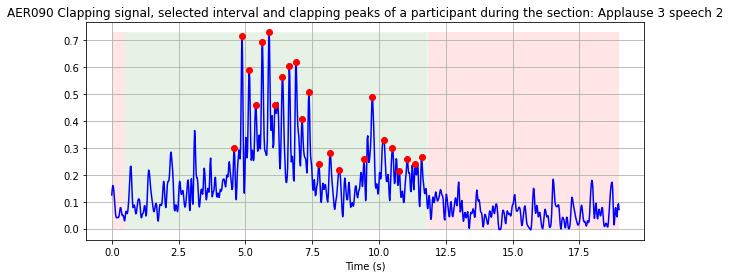

[72, 0.3457416719911246, 52, 0.4271499688069186]
[48, 0.2559437105940607, 42, 0.32819387875284844]
[68, 0.8524986407888941, 67, 0.8167512273008037]
[84, 0.3891929182094089, 71, 0.32719029918588294]
[69, 0.4537665864386169, 55, 0.2674970821393389]
[61, 0.4318686540353027, 57, 0.6869332988962525]
[39, 0.7135361208882689, 39, 0.6744443297376789]
[85, 0.41888149080292447, 72, 0.42437665493579174]
[49, 0.4105931810765846, 47, 0.3379384628679868]
[72, 0.441278070454588, 50, 0.6321174620103694]
[75, 0.21918466337500617, 56, 0.20907594344939262]
[75, 0.6295818758647345, 60, 0.5114460670523704]
[21, 0.41925145511853884, 19, 0.7253590337780575]
[73, 0.307708345679676, 49, 0.4298312921503622]
[70, 0.20288417915740573, 36, 0.2987294037577131]
[78, 0.3182525413168824, 65, 0.3334601178589279]
[82, 0.34945652980541164, 68, 0.25898603814255616]
[64, 0.8122559933348976, 62, 0.6164649434535331]
[73, 0.2757104613245149, 54, 0.3871935484593624]
[74, 0.47472702088036783, 55, 0.6050455743289961]
[0, 0, 0, n

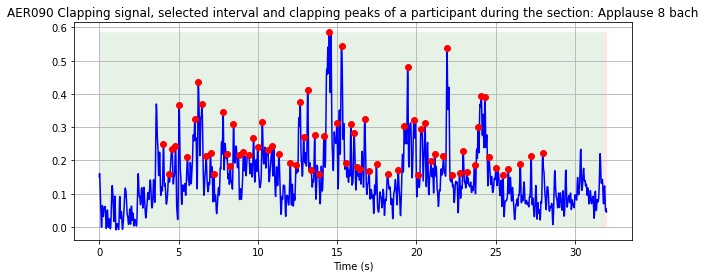

[58, 0.31692183550154246, 48, 0.39551528355636795]
[55, 0.30042566420392786, 20, 0.11998795708105832]
[60, 0.9875049418309554, 56, 0.5841388414785501]
[50, 0.39882872804415614, 46, 0.3542295854371295]
[61, 0.16171734911599311, 52, 0.15119339128673862]
[43, 0.7205775539434436, 35, 0.8530335174508419]
[38, 1.0045258734483278, 38, 0.7590375031257327]
[49, 0.3254294980502379, 43, 0.3301852238895035]
[39, 0.5069645889103118, 37, 0.329368199948071]
[55, 0.5995805378908409, 35, 0.7959561761953551]
[51, 0.2495388979651545, 48, 0.11897197682265465]
[52, 0.38426746386927263, 49, 0.4006534437963857]
[20, 0.416036995364666, 18, 0.684690341266533]
[46, 0.32971772203252614, 42, 0.36763777122766106]
[59, 0.18778630072904098, 21, 0.11279197783862176]
[52, 0.6839821818144656, 41, 0.5269761017657606]
[0, 0, 0, nan]
[0, 0, 0, nan]
[48, 0.32713946162075963, 45, 0.33684548623651966]
[58, 0.4247209963431528, 40, 0.5053020705013822]
[48, 0.402174809344666, 32, 0.3278966964453911]
[46, 0.25592356112635334, 43

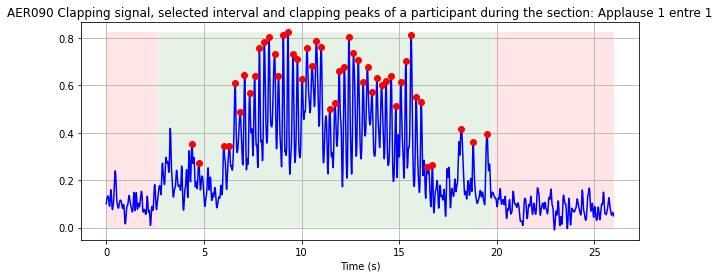

[54, 0.6172825858548736, 41, 0.3200631783481571]
[47, 0.7514964187730059, 29, 0.4449047326544601]
[70, 0.8371386417120958, 60, 0.7326560352408025]
[48, 1.0492954823975542, 47, 0.6076592886679149]
[36, 0.4004635841161954, 36, 0.24882059681781835]
[58, 0.5410729830095143, 45, 0.5048881072672546]
[38, 0.9145773271916484, 35, 0.5917680533949843]
[57, 0.8194378524179011, 56, 0.6581857359133287]
[49, 0.7244254412685347, 48, 0.5098866488312815]
[52, 0.7975672639061091, 25, 0.5462199685087027]
[35, 0.38952075037538614, 33, 0.40336979215073027]
[46, 0.5827240350656158, 46, 0.37887262621783635]
[43, 0.7028997847589805, 41, 1.229263340502042]
[46, 0.5010418327119585, 44, 0.6770135949551032]
[54, 0.27083029286884136, 40, 0.26582561091046053]
[48, 0.54186266979501, 34, 0.23179304934230174]
[54, 0.40648290975609613, 54, 0.26606418818195027]
[55, 1.3050262298667588, 55, 0.776150821478894]
[68, 0.5525530926460228, 57, 0.4345750401402344]
[26, 0.8234489627176884, 24, 0.4813301991400154]
[0, 0, 0, nan]


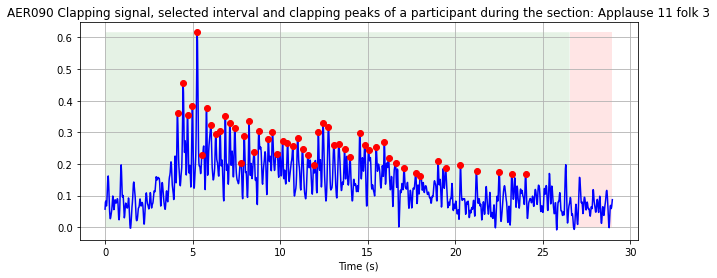

[306, 0.8540301630906355, 100, 0.28470388469901003]
[276, 0.8096502045253873, 259, 0.5247936020057989]
[271, 1.5705114832640223, 243, 0.8724420933184309]
[322, 1.7199071121190108, 142, 0.6308603315245391]
[326, 0.47327284631275657, 235, 0.21455100036985458]
[292, 0.7463045989337, 270, 0.9420304672480797]
[319, 1.6623035215503554, 250, 0.7501302059356543]
[308, 0.9872932270652028, 274, 0.623171735816018]
[279, 0.7366064145409831, 215, 0.4194042668954047]
[302, 1.1316435179329931, 247, 0.602949692228921]
[329, 0.5524560645602777, 230, 0.4199422509597534]
[298, 0.5383111364947497, 180, 0.3474596013723174]
[331, 0.5833151687038415, 165, 1.0511175402272852]
[20, 0.8407241669001175, 14, 0.5561146704402976]
[327, 0.2951722080116438, 273, 0.3093005084916244]
[291, 1.3072880563207152, 237, 0.756987119841161]
[328, 0.750574295103102, 283, 0.5238462690791988]
[298, 1.3933705804624912, 238, 0.5850849292310959]
[332, 0.6550876682591851, 307, 0.5213833945096187]
[333, 1.094424184704553, 201, 0.47390

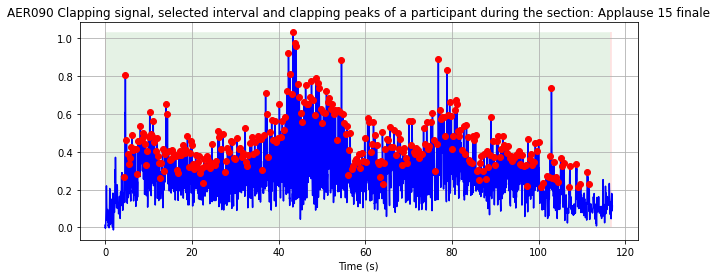

[51, 0.4061374107349088, 30, 0.28407884841992603]
[0, 0, 0, nan]
[0, 0, 0, 1.2118464088166494]
[64, 0.5973600804926921, 56, 0.43546185570518464]
[43, 0.2564915561037368, 41, 0.17794248356814032]
[44, 0.8774632276663084, 43, 0.7840307218836644]
[35, 0.8332785479340536, 35, 0.7448197180664756]
[0, 0, 0, nan]
[39, 0.3339294073881034, 29, 0.20023828625403825]
[0, 0, 0, nan]
[51, 0.20050778049970017, 39, 0.2790570904070539]
[55, 0.5221396443483722, 45, 0.5939403659245698]
[34, 0.3437496020195879, 25, 0.5401831355467037]
[50, 1.2550189258570157, 36, 0.7077150682141893]
[0, 0, 0, 0.3266426867431682]
[0, 0, 0, nan]
[58, 0.383973142376386, 50, 0.2966024320239729]
[0, 0, 0, nan]
[59, 0.15947673137167304, 36, 0.12383618697052849]
[58, 0.6482087533901033, 46, 0.5303362735469448]
[0, 0, 0, nan]
[53, 0.235435702302527, 39, 0.20015183100746242]
[54, 0.7267578567214701, 46, 0.5127078120220584]
[0, 0, 0, nan]
[60, 0.28337585641686436, 28, 0.1789894637662659]
[0, 0, 0, nan]
[39, 0.3026894476985843, 27, 

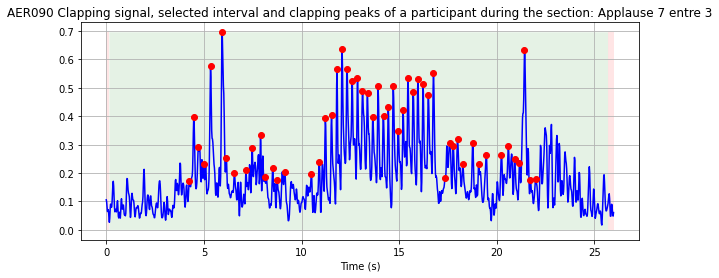

[48, 0.625849751993502, 39, 0.3450295080222774]
[32, 1.1134481355802022, 23, 0.5307966853162893]
[51, 1.4098110769419228, 50, 0.7590142520555901]
[51, 0.6540947858899835, 42, 0.32655977528248864]
[32, 0.4085352377609078, 32, 0.23314044391299352]
[21, 0.4882335897898889, 21, 0.38137030491819823]
[18, 0.8596982974593826, 18, 0.5135080907778209]
[47, 1.1256189926070137, 47, 0.6936991353196508]
[34, 0.6424290618404034, 27, 0.35990080223057114]
[36, 1.161475646232191, 34, 0.6290044569936425]
[29, 0.2774772631731493, 23, 0.3577757037402588]
[34, 0.7179091911504147, 31, 0.38167127953902275]
[16, 0.49730354326536713, 15, 0.8852337769902007]
[34, 0.2741915844549339, 30, 0.31337637383967104]
[50, 0.2297814410520353, 22, 0.22460167398021824]
[31, 1.0479487003062926, 31, 0.5804073498937321]
[42, 0.7605111486462921, 38, 0.37185091216826544]
[26, 1.1742068197476607, 23, 0.4922358050297867]
[36, 0.19352036664001288, 26, 0.23271550417734715]
[16, 0.635208667044147, 10, 0.271681769903425]
[0, 0, 0, nan

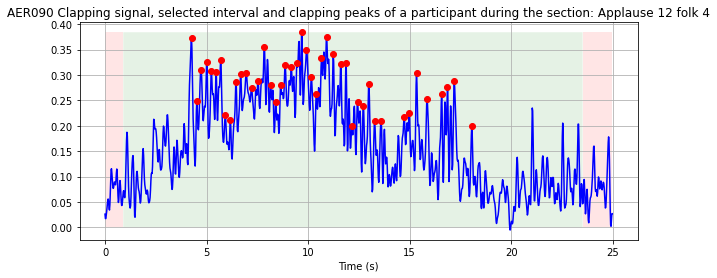

[0, 0, 0, nan]
[0, 0, 0, nan]
[218, 0.9501286145663699, 127, 0.6815906859061532]
[207, 0.5514052333236277, 201, 0.34969002504265406]
[186, 0.2902079455401356, 172, 0.286952500886133]
[172, 0.6179805303972571, 161, 1.0351715921739462]
[167, 0.6115362816993817, 137, 0.5663234802522253]
[206, 0.43011123496366854, 184, 0.3352355362350718]
[143, 0.4600351530550425, 73, 0.2677593714321166]
[173, 0.9135700434912051, 133, 1.03402670519815]
[203, 0.2181537331360068, 185, 0.2471168675090108]
[161, 0.42090074786278536, 150, 0.673424740162593]
[162, 0.43876407923030636, 51, 0.7892143944630047]
[196, 0.49240847988476616, 137, 0.7390673460908362]
[167, 0.4906189847962934, 128, 0.892493751700731]
[185, 0.20279394587185254, 133, 0.2992274754526825]
[0, 0, 0, nan]
[206, 0.8303165553971479, 96, 0.391135937266584]
[191, 0.31445995726833076, 127, 0.4767233497394198]
[199, 0.371361447044958, 180, 0.42634882233775895]
[0, 0, 0, nan]
[194, 0.311325426629032, 176, 0.4637279777519118]
[217, 0.3463831254579004,

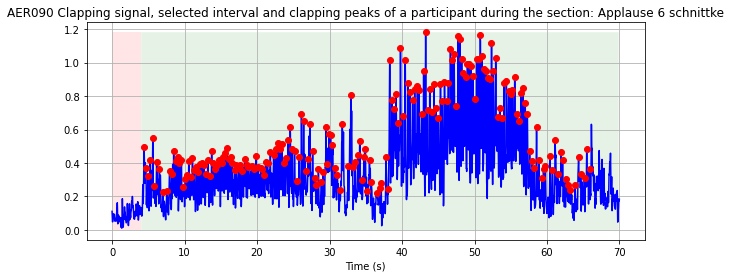

[19, 0.11454661556510409, 11, 0.07548874561450722]
[0, 0, 0, 0.028010110355838325]
[14, 1.0497946988612772, 1, 0.5156204862987256]
[20, 0.3823717332953457, 14, 0.18334345209288025]
[0, 0.5894826063661694, 0, 0.2561486394516702]
[0, 0.18829691503888524, 0, 0.07167044315550586]
[0, 0.5232116752755995, 0, 0.26849642279571984]
[13, 0.5982004118798232, 1, 0.2614839052878444]
[20, 0.2650706181358831, 2, 0.10123856013813033]
[0, 0.5886433431672403, 0, 0.3111129291186487]
[3, 0.19616415154307176, 1, 0.07539788249302856]
[16, 0.403648470298474, 5, 0.1592617106674398]
[4, 0.22824812706157888, 2, 0.10046379568090827]
[0, 0.3713656315685847, 0, 0.1521385157459107]
[14, 0.20244688114125384, 5, 0.09491309866828403]
[0, 0, 0, 0.01878346155956321]
[17, 0.38816899727789167, 13, 0.1849894462804198]
[0, 0.9583554643350417, 0, 0.44465518147571265]
[0, 0, 0, 0.030096334429609503]
[17, 0.6702478746354078, 1, 0.277140410997532]
[0, 0, 0, nan]
[0, 0, 0, nan]
[0, 0.4899857149977851, 0, 0.19253040276914063]
[0,

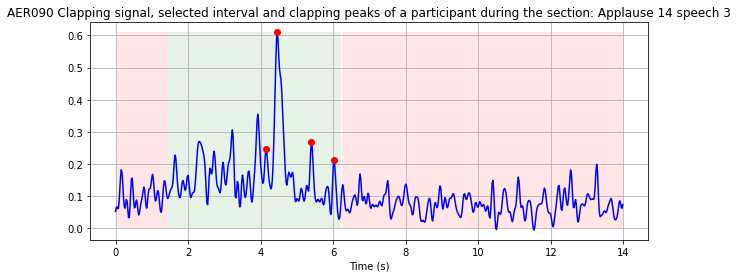

[69, 0.2793361359698089, 55, 0.27860487442465715]
[30, 0.31591195295141605, 30, 0.34384625285723286]
[53, 0.9470974234517574, 53, 0.8375871944010347]
[60, 0.5442654438966216, 57, 0.29302975717009355]
[39, 0.3863929814394811, 39, 0.26855335176700207]
[34, 0.39223102542001265, 34, 0.4842728682897992]
[34, 0.5484755387262155, 28, 0.5859958352247296]
[44, 0.6101355876980785, 44, 0.5110047731060202]
[35, 0.5018463474526735, 33, 0.3520008744654889]
[47, 0.7886368803070377, 41, 0.641609758772729]
[53, 0.21334009167483042, 44, 0.2185960544696092]
[43, 0.5794007546699599, 34, 0.4021392571750952]
[38, 0.46972139893199194, 16, 0.807546218675349]
[47, 0.5724944784479051, 46, 0.7769284419195348]
[64, 0.16475393737217528, 34, 0.20642858812633008]
[58, 0.5220659451535418, 35, 0.37568445643238907]
[41, 0.4478476265302267, 39, 0.30339676696356604]
[65, 0.7231972822452539, 41, 0.4153290511512213]
[49, 0.3530448058749711, 34, 0.3313961061652356]
[48, 0.5717493265447802, 27, 0.28828935585227755]
[0, 0, 0,

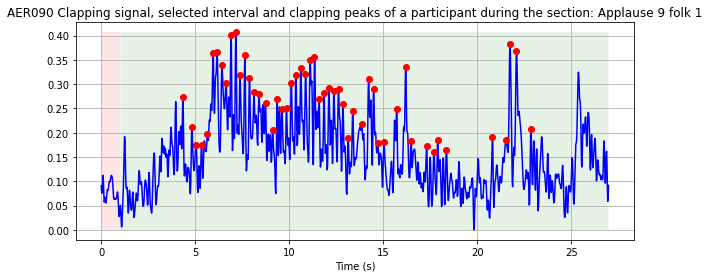

[30, 0.5827460095621462, 13, 0.3372507030625516]
[0, 0, 0, nan]
[21, 0.8937360026660832, 21, 0.6652378555692477]
[22, 0.44493323551104225, 22, 0.33636278801603253]
[15, 0.5048038796775651, 14, 0.2131534879792531]
[15, 0.5367776260199218, 15, 0.36806088372755147]
[14, 0.6719777356666289, 13, 0.5253388594360824]
[28, 0.149931379675627, 20, 0.09928267645655006]
[16, 0.5356647355780517, 15, 0.35678823526226544]
[15, 1.3141304626248282, 15, 0.8724128576076123]
[18, 0.303597652814085, 14, 0.1585442880767847]
[14, 0.3642739536751067, 14, 0.28170613072496936]
[14, 0.4715689055925267, 13, 0.6993865524915326]
[31, 0.19845456624632152, 21, 0.14977484359733162]
[0, 0.7177212800320931, 0, 0.3014784541905363]
[20, 0.7745151548815175, 20, 0.4931423796717787]
[0, 0, 0, nan]
[0, 0, 0, nan]
[11, 0.7274069035498226, 7, 0.2789217874777541]
[27, 0.4466709324021999, 8, 0.21045628241174608]
[32, 0.24884122630865543, 14, 0.12379710329744203]
[20, 0.33406858530524125, 14, 0.21329968940534005]
[18, 0.6689937166

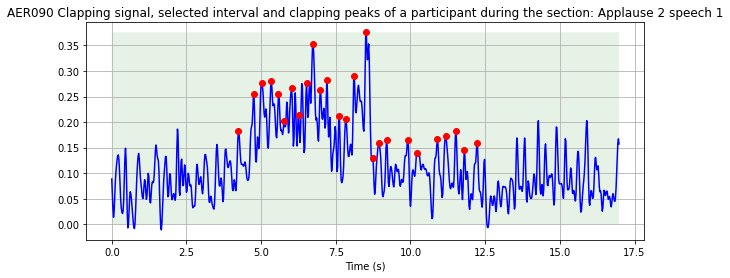

[65, 0.3000695314692522, 62, 0.2510878248828943]
[58, 0.3050346682121161, 50, 0.3143819435735407]
[57, 0.7859565673546347, 49, 0.6841385500548645]
[58, 0.7012775998530202, 58, 0.4871192611985717]
[47, 0.47797845972391095, 45, 0.295177218849971]
[62, 0.351248350244023, 22, 0.5266774296496111]
[21, 1.0628733014432674, 21, 0.7447203960931926]
[58, 0.6218645008689463, 45, 0.4083999034416881]
[40, 0.48356821803409444, 37, 0.3066098484733687]
[55, 0.7417384982853521, 38, 0.5630841146873163]
[61, 0.23375275154452763, 45, 0.25474798045810965]
[40, 0.47543084875644104, 39, 0.36168349619626416]
[48, 0.6677700920534149, 12, 0.7943866719963509]
[48, 0.3997032637591228, 45, 0.5053722744055417]
[54, 0.23592098457264893, 46, 0.2097575952580155]
[46, 0.6256156358067142, 39, 0.3451238866768981]
[59, 0.37109732696129694, 29, 0.31870296952220456]
[57, 0.9850666229569762, 57, 0.6613856421296777]
[54, 0.30696589185971307, 36, 0.305708365480549]
[62, 0.4724628282834379, 55, 0.42766598356167934]
[0, 0, 0, na

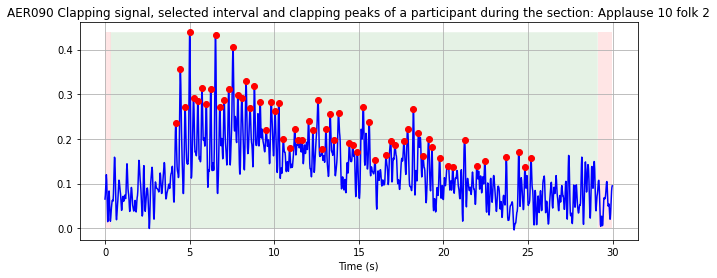

[39, 0.6056915449757262, 39, 0.3594889888796199]
[23, 0.5364511647546686, 23, 0.40866080584803266]
[39, 1.118881927381078, 39, 0.8121472740088148]
[35, 0.7294113592310291, 34, 0.49928912603542447]
[28, 0.3875028161159375, 27, 0.20118662656714426]
[23, 0.26038812005276496, 21, 0.3808665646502378]
[46, 0.8215593042404141, 28, 0.8044719985504709]
[31, 0.7469386802754621, 31, 0.6163112111731597]
[29, 0.8095431678715221, 27, 0.4285454164216098]
[30, 0.9989642721639933, 30, 0.6435067080798859]
[28, 0.35095343147662, 20, 0.3120684692694788]
[27, 0.5727413582801258, 26, 0.3602624494393434]
[21, 0.7106408255705731, 20, 1.3213373338833592]
[38, 0.6077859147458098, 36, 0.5342476855304622]
[46, 0.5597003245955339, 33, 0.9052491394290135]
[33, 0.4372348694354783, 27, 0.5644583275064072]
[38, 0.5122215108186027, 38, 0.3271574751149851]
[24, 0.7233686622958102, 24, 0.36544088038357364]
[25, 0.4839067543589689, 22, 0.30437214642205795]
[42, 0.731796930428786, 28, 0.4351015420182817]
[0, 0, 0, nan]
[0,

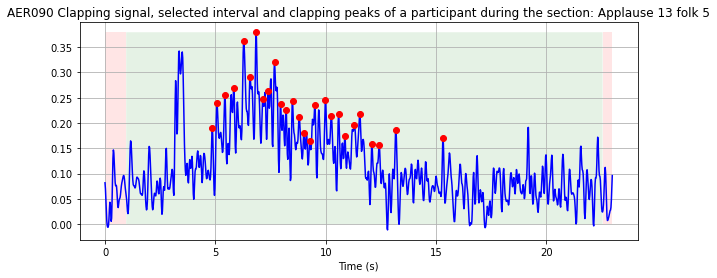

In [65]:
# clappings using the early signal threshold , pre applause onset.

# for every clapping event
for f in list_files:
    # check if a csv file
    if not f.endswith('.csv'):
        continue

    # read data
    df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
    df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
    df_ev = df_motion.copy()
    extend_ind = 4*fs # extended clapping range by 5 s from fuzzy onset (s)
    #extend_ind = 0
    seg_len=len(df_motion)


    # create csv files
    df_trimmed = pd.DataFrame(index=df_ev.index)
    df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
    df_rms = pd.DataFrame(columns=df_ev.columns)

    thr_list = []

    # for every participant
    for i, col in enumerate(df_ev.columns):
        # thresholding from first 5 seconds of motion (pre clapping)
        rms = rms_signal(df_ev.loc[:5,col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
        std = np.std(df_ev[col])
        thr = rms.mean()[0] + std*1 #0.5
        thr = 0 if np.isnan(thr) else thr
        std_thr = 0.05 # Finn editied Nov 22
        # discard if std of signal is below std_thr
        thr = 0 if std<=std_thr else thr
        thr_list.append(thr)

        # save rms
        df_rms[col] = rms['rms']

        # in out pins 
        # set motion measure to nan for range:
#             1. outside of interest zone
#             2. below threshold (adapted rms)
        # Extends the window 10 timestamps at both ends
        extend = 10 * 0.02 # 0.2 s
        if not (thr == 0):
            in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
            out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
        else:
            in_  = 0
            out_ = 0
        df_ev.loc[:in_,col] = np.nan
        df_ev.loc[out_:,col] = np.nan

        # peaks
        peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
        
        # cut the peaks outside of the clapping range (not peaks because not audible in audio)
        peak_index_list=peak_index_list[peak_index_list>=extend_ind]
        peak_index_list=peak_index_list[peak_index_list<=seg_len-extend_ind]
        
        # cut the peaks that do not exceed the rms threshold
        s_plot = df_ev[col].iloc[peak_index_list]
        s_plot = s_plot[s_plot>thr]
        print([len(peak_index_list),thr,len(s_plot),std])

        # trim first and last peaks, + extend
        # Extends the window 10 timestamps at both ends after trimming the
        # signal based on first and last claps
        df_peaks.loc[:,col] = np.nan
        
        if not s_plot.notna().sum() == 0:
            if s_plot.notna().sum()/df_motion.index[-1]<4: # last catch on extrem noise. Clapping should never be so numerous
                in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
                out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
                in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
                out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
                df_ev.loc[:in_peak,col] = np.nan
                df_ev.loc[out_peak:,col] = np.nan
                
                df_peaks.loc[s_plot.index,col] = s_plot.values

        # write to df
        df_trimmed[col] = df_ev[col].values
        

        # end devices loop

    # save as csv files
    csv_trimmed_output_dir = DIR + '/clapping_trimmed/'
    df_trimmed_save = df_trimmed.copy()
    df_trimmed_save.index.name = 'index'
    df_trimmed_save.index = pd.date_range(0, periods=len(df_trimmed_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_trimmed_save.to_csv(csv_trimmed_output_dir + f.replace('motion', 'trimmed'))

    csv_peaks_output_dir = DIR + '/clapping_peaks/'
    df_peaks_save = df_peaks.copy()
    df_peaks_save.index.name = 'index'
    df_peaks_save.index = pd.date_range(0, periods=len(df_peaks_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_peaks_save.to_csv(csv_peaks_output_dir + f.replace('motion', 'peaks'))

    #   # plot
    plt.figure(figsize = [10,4])
    
#     i = -1 # participant idx
    plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

    if df_peaks.loc[:,col].sum()>0:
        
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

    plt.title(col + ' Clapping signal, selected interval and clapping peaks of a participant during the section: ' + ' '.join(f.split('_')[:-1]))
    plt.xlabel('Time (s)')
    plt.grid()
    plt.show()
  # end clappings loop

    csv_trimmed_output_dir, os.listdir(csv_trimmed_output_dir), csv_peaks_output_dir, os.listdir(csv_peaks_output_dir)

The choices of claps on this AX3 sensors are particularly unreliable. It would be good to revist the thresholding criteria, given that we aren't normalising by median difference any more.